# Cognitive Services Personalizer 
https://github.com/Azure-Samples/cognitive-services-personalizer-samples

This tutorial simulates a Personalizer loop _system_ which suggests which type of coffee a customer should order. The users and their preferences are stored in a [user dataset](users.json). Information about the coffee is also available in a [coffee dataset](coffee.json).

A summary of the user information is:

|Customers|Times of Day|Types of weather|
|--|--|--|
|Alice<br>Bob<br>Cathy<br>Dave|Morning<br>Afternoon<br>Evening|Sunny<br>Rainy<br>Snowy| 

To help Personalizer make the correct coffee selection for each person, the _system_ also knows details about the coffee.

|Types of temperature|Places of origin|Types of roast|Organic|
|--|--|--|--|
|Hot<br>Cold|Kenya<br>Brazil<br>Ethiopia|Dark<br>Light|Organic<br>Not organic|

The **purpose** of the Personalizer loop is to find the best match between the users and the coffee as much of the time as possible. 

## How the simulation works

At the beginning of the running system, the suggestions from Personalizer are only successful between 20% to 30% (indicated by the reward score of 1). After some requests, the system improves.

After the initial 10,000 requests, run an offline evaluation. This allows Personalizer to review the data and suggest a better learning policy. Apply the new learning policy and run the notebook again with 2,000 requests. The loop will perform better.

## Rank and reward calls

For each of the few thousand calls to the Personalizer service, the Azure notebook sends the **Rank** request to the REST API:

* A unique ID for the Rank/Request event
* Context - A random choice of the user, weather, and time of day - simulating a user on a website or mobile device
* Features - _All_ the coffee data - from which Personalizer makes a suggestion

The system receives the rank of the coffee choices, then compares that prediction with the user's known choice for the same time of day and weather. If the known choice is the same as the predicted choice, the **Reward** of 1 is sent back to Personalizer. Otherwise the reward is 0. 

> [!Note]
> This is a simulation so the algorithm for the reward is simple. In a real-world scenario, the algorithm should use business logic, possibly with weights for various aspects of the customer's experience, to determine the reward score. 

## Prerequisites

* An [Azure Personalizer resource](https://azure.microsoft.com/try/cognitive-services/). 
    * If you have already used the Personalizer resource, make sure to [clear the data]() in the Azure portal for the resource. 
* Upload all the files for [this sample](https://github.com/Azure-Samples/cognitive-services-personalizer-samples/tree/master/samples/azurenotebook) into an Azure Notebook project.  


File descriptions:

* [Personalizer.ipynb](https://github.com/Azure-Samples/cognitive-services-personalizer-samples/blob/master/samples/azurenotebook/Personalization.ipynb)
* [User dataset](https://github.com/Azure-Samples/cognitive-services-personalizer-samples/blob/master/samples/azurenotebook/users.json) is stored in a JSON object.
* [Coffee dataset](https://github.com/Azure-Samples/cognitive-services-personalizer-samples/blob/master/samples/azurenotebook/coffee.json) is stored in a JSON object. 
* [Example Request JSON](https://github.com/Azure-Samples/cognitive-services-personalizer-samples/blob/master/samples/azurenotebook/example-rankrequest.json) is the expected format for a POST request to the Rank API.

## Configure Personalizer resource

In the Azure portal, configure your [Personalizer resource](https://ms.portal.azure.com/#create/Microsoft.CognitiveServicesPersonalizer) with the **update model frequency** set to 15 seconds and a **reward wait time** of 15 seconds. These settings are found on the **[Settings](how-to-settings.md#configure-service-settings-in-the-azure-portal)** page. 

|Setting|Value|
|--|--|
|update model frequency|15 seconds|
|reward wait time|15 seconds|

These values have a very short duration in order to show changes in this tutorial. These values shouldn't be used in a production scenario without validating they achieve your goal with your Personalizer loop. 

## Set up the Azure Notebook

Change the Kernel to `Python 3.6`. 


## Run Notebook cells

Run each executable cell and wait for it to return. 

You know it is done when the brackets next to the cell display a number instead of a `*`. Do not continue if you get an error. 

The following sections explain what each cell does programmatically and what to expect for the output. 

### Include the python modules

Include the required python modules. The cell has no output.

In [17]:
import json
import matplotlib.pyplot as plt
import random 
import requests
import time
import uuid
import datetime

### Set Personalizer resource key and name

Change the value of `<your-resource-name>` to your Personalizer resource's name. Change the value of `<your-resource-key>` to own of your Personalizer keys on the **Keys** page from the Azure portal. 

The cell has no output.

In [18]:
# Replace 'personalization_base_url' and 'resource_key' with your valid endpoint values.
personalization_base_url = "https://diberry-personalizer-10-01-03.cognitiveservices.azure.com/"
resource_key = "6f4d927bafc74ead9b174861c11b94b7"

### Print current data and time
Use this function to note the start and end times of the iterative function, `iterations`.

In [19]:
# Print out current datetime
def currentDateTime():
    currentDT = datetime.datetime.now()
    print (str(currentDT))

### Get the last model update date and time

When the function, `get_last_updated`, is called, the function prints out the last modified date and time that the model was updated. The cell has no output. The function does output the last model training date when called.

The function uses a GET REST API to [get model properties](https://westus2.dev.cognitive.microsoft.com/docs/services/personalizer-api/operations/GetModelProperties). 

In [20]:
# ititialize variable for model's last modified date
modelLastModified = ""

In [21]:
def get_last_updated(currentModifiedDate):
    
    print('-----checking model')
    
    # get model properties
    response = requests.get(personalization_model_properties_url, headers = headers, params = None)
    
    print(response)
    print(response.json())
    
    # get lastModifiedTime
    lastModifiedTime = json.dumps(response.json()["lastModifiedTime"])
    
    if (currentModifiedDate != lastModifiedTime):
        currentModifiedDate = lastModifiedTime
        print(f'-----model updated: {lastModifiedTime}')

### Get policy and service configruation

Validate the state of the service with these two REST calls.

In [22]:
def get_service_settings():
    
    print('-----checking service settings')
    
    # get learning policy
    response = requests.get(personalization_model_policy_url, headers = headers, params = None)
    
    print(response)
    print(response.json())
    
    # get service settings
    response = requests.get(personalization_service_configuration_url, headers = headers, params = None)
    
    print(response)
    print(response.json())


### Construct URLs for REST calls and read JSON data files

This cell 

* builds the URLs used in REST calls 
* sets the security header using your Personalizer resource key 
* sets the random seed for the Rank event ID
* reads in the JSON data files
* calls `get_last_updated` method - learning policy has been removed in example output
* calls `get_service_settings` method

The cell has output from the call to `get_last_updated` and `get_service_settings` functions, which is the date of the last model training update. The date looks like: 

```python
-----checking model
<Response [200]>
{'creationTime': '0001-01-01T00:00:00+00:00', 'lastModifiedTime': '0001-01-01T00:00:00+00:00'}
-----model updated: "0001-01-01T00:00:00+00:00"
-----checking service settings
<Response [200]>
{...learning policy...}
<Response [200]>
{'rewardWaitTime': '00:00:15', 'defaultReward': 0.0, 'rewardAggregation': 'earliest', 'explorationPercentage': 0.2, 'modelExportFrequency': '00:00:15', 'logRetentionDays': -1}
User count 4
Coffee count 4
```

Verify that the `rewardWaitTime` and the `modelExportFrequency` are both set to 15 seconds. 

In [23]:
# build URLs
personalization_rank_url = personalization_base_url + "personalizer/v1.0/rank"
personalization_reward_url = personalization_base_url + "personalizer/v1.0/events/" #add "{eventId}/reward"
personalization_model_properties_url = personalization_base_url + "personalizer/v1.0/model/properties"
personalization_model_policy_url = personalization_base_url + "personalizer/v1.0/configurations/policy"
personalization_service_configuration_url = personalization_base_url + "personalizer/v1.0/configurations/service"
headers = {'Ocp-Apim-Subscription-Key' : resource_key, 'Content-Type': 'application/json'}

# context
users = "users.json"

# action features
coffee = "coffee.json"

# empty JSON for Rank request
requestpath = "example-rankrequest.json"

# initialize random
random.seed(time.time())

userpref = None 
rankactionsjsonobj = None 
actionfeaturesobj = None

with open(users) as handle:
    userpref = json.loads(handle.read())

with open(coffee) as handle:
    actionfeaturesobj = json.loads(handle.read())
    
with open(requestpath) as handle:
    rankactionsjsonobj = json.loads(handle.read())  
    
get_last_updated(modelLastModified)
get_service_settings()

print(f'User count {len(userpref)}')
print(f'Coffee count {len(actionfeaturesobj)}')

-----checking model
<Response [200]>
{'creationTime': '0001-01-01T00:00:00+00:00', 'lastModifiedTime': '0001-01-01T00:00:00+00:00'}
-----model updated: "0001-01-01T00:00:00+00:00"
-----checking service settings
<Response [200]>
{'name': '34a505f8329248abab06ebfc7192056b', 'arguments': '--cb_explore_adf --epsilon 0.2 --dsjson --cb_type mtr --marginal i -q Fi -q Fj -l 0.1 --power_t 0'}
<Response [200]>
{'rewardWaitTime': '00:05:00', 'defaultReward': 0.0, 'rewardAggregation': 'earliest', 'explorationPercentage': 0.2, 'modelExportFrequency': '00:05:00', 'logRetentionDays': -1}
User count 4
Coffee count 4


### Troubleshooting the first REST call

This previous cell is the first cell that calls out to Personalizer. Make sure the REST status code in the output is 200. If you get an error, such as 404, but you are sure your resource key and name are correct, reload the notebook.

Make sure the count of coffee and users is both 4. If you get an error, check that you uploaded all 3 JSON files. 

### Generate a unique event ID

This function generates a unique ID for each rank call. The ID is used to identify the rank and reward call information. This value could come from a business process such as a web view ID or transaction ID.

The cell has no output. The function does output the unique ID when called.

In [7]:
def add_event_id(rankjsonobj):
    eventid = uuid.uuid4().hex
    rankjsonobj["eventId"] = eventid
    return eventid

### Get random user, weather, and time of day

This function selects a unique user, weather, and time of day, then adds those items to the JSON object to send to the Rank request.

The list of 4 users and their preferences - only some preferences are shown for brevity: 

```json
{
  "Alice": {
    "Sunny": {
      "Morning": "Cold brew",
      "Afternoon": "Iced mocha",
      "Evening": "Cold brew"
    }...
  },
  "Bob": {
    "Sunny": {
      "Morning": "Cappucino",
      "Afternoon": "Iced mocha",
      "Evening": "Cold brew"
    }...
  },
  "Cathy": {
    "Sunny": {
      "Morning": "Latte",
      "Afternoon": "Cold brew",
      "Evening": "Cappucino"
    }...
  },
  "Dave": {
    "Sunny": {
      "Morning": "Iced mocha",
      "Afternoon": "Iced mocha",
      "Evening": "Iced mocha"
    }...
  }
}
```

In [8]:
def add_random_user_and_contextfeatures(namesoption, weatheropt, timeofdayopt, rankjsonobj):   
    name = namesoption[random.randint(0,3)]
    weather = weatheropt[random.randint(0,2)]
    timeofday = timeofdayopt[random.randint(0,2)]
    rankjsonobj['contextFeatures'] = [{'timeofday': timeofday, 'weather': weather, 'name': name}]
    return [name, weather, timeofday]


### Add all coffee data

This function adds the entire list of coffee to the JSON object to send to the Rank request. 

The cell has no output. The function does change the `rankjsonobj` when called.


The example of a single coffee's features is: 

```json
{
    "id": "Cappucino",
    "features": [
    {
        "type": "hot",
        "origin": "kenya",
        "organic": "yes",
        "roast": "dark"
        
    }
}
```

In [9]:
def add_action_features(rankjsonobj):
    rankjsonobj["actions"] = actionfeaturesobj

### Compare Rank API's prediction with known user preference

This function compares the user's preference for coffee, based on weather and time of day, with the Personalizer's suggestion for the user for those filters. If the suggestion matches, a score of 1 is returned, otherwise the score is 0. The cell has no output. The function does output the score when called.

In [10]:
def get_reward_from_simulated_data(name, weather, timeofday, prediction):
    if(userpref[name][weather][timeofday] == str(prediction)):
        return 1 
    return 0

### Loop through calls to Rank and Reward

The next cell is the _main_ work of the Notebook, getting a random user, getting the coffee list, sending both to the Rank API. Comparing the prediction with the user's known preferences, then sending the reward back to the Personalizer service. 

The loop runs for `num_requests` times, currently set to 4000. This number is meant to indicate that Personalizer needs a few thousand requests before its first retraining, regardless of the duration of the update model frequency. If the frequency was an five minutes or an hour, the service still needs a few thousand calls to Rank and Reward to create an effective learning policy. 

An example of the JSON sent to the Rank API follows. The list of coffee is not complete, for brevity. You can see the entire JSON for coffee in `coffee.json`.


```json
{ 
   'contextFeatures':[ 
      { 
         'timeofday':'Evening',
         'weather':'Snowy',
         'name':'Alice'
      }
   ],
   'actions':[ 
      { 
         'id':'Cappucino',
         'features':[ 
            { 
               'type':'hot',
               'origin':'kenya',
               'organic':'yes',
               'roast':'dark'
            }
         ]
      }
        ...rest of coffee list
   ],
   'excludedActions':[ 

   ],
   'eventId':'b5c4ef3e8c434f358382b04be8963f62',
   'deferActivation':False
}
```

Then display the JSON sent to the Rank API:

```console
To:  {'contextFeatures': [{'timeofday': 'Morning', 'weather': 'Sunny', 'name': 'Bob'}], 'actions': [{'id': 'Cappucino', 'features': [{'type': 'hot', 'origin': 'kenya', 'organic': 'yes', 'roast': 'dark'}]}, {'id': 'Cold brew', 'features': [{'type': 'cold', 'origin': 'brazil', 'organic': 'yes', 'roast': 'light'}]}, {'id': 'Iced mocha', 'features': [{'type': 'cold', 'origin': 'ethiopia', 'organic': 'no', 'roast': 'light'}]}, {'id': 'Latte', 'features': [{'type': 'hot', 'origin': 'brazil', 'organic': 'no', 'roast': 'dark'}]}], 'excludedActions': [], 'eventId': '5001bcfe3bb542a1a238e6d18d57f2d2', 'deferActivation': False}
```

Then display the results from the Rank API:

```
From:  {'ranking': [{'id': 'Latte', 'probability': 0.85}, {'id': 'Iced mocha', 'probability': 0.05}, {'id': 'Cappucino', 'probability': 0.05}, {'id': 'Cold brew', 'probability': 0.05}], 'eventId': '5001bcfe3bb542a1a238e6d18d57f2d2', 'rewardActionId': 'Latte'}
```

Finally, each loop shows the random selection of user, weather, time of day, and determined reward.

```console
1 Alice Rainy Morning Latte 1
```

The function uses:

* Rank: a POST REST API to [get rank](https://westus2.dev.cognitive.microsoft.com/docs/services/personalizer-api/operations/Rank). 
* Reward: a POST REST API to [report reward](https://westus2.dev.cognitive.microsoft.com/docs/services/personalizer-api/operations/Reward).

In [11]:
def iterations(n, modelCheck, jsonFormat):

    i = 1
    
    # default reward value - assumes failed prediction
    reward = 0

    # Print out dateTime
    #currentDateTime()

    # collect results to aggregate in graph
    total = 0
    rewards = []
    count = []

    # default list of user, weather, time of day
    namesopt = ['Alice', 'Bob', 'Cathy', 'Dave']
    weatheropt = ['Sunny', 'Rainy', 'Snowy']
    timeofdayopt = ['Morning', 'Afternoon', 'Evening']
    
    
    while(i <= n):

        # create unique id to associate with an event
        eventid = add_event_id(jsonFormat)

        # generate a random sample
        [name, weather, timeofday] = add_random_user_and_contextfeatures(namesopt, weatheropt, timeofdayopt, jsonFormat)

        # add action features to rank
        add_action_features(jsonFormat) 

        # show JSON to send to Rank
        #print('To: ', jsonFormat)    

        # choose an action - get prediction from Personalizer
        response = requests.post(personalization_rank_url, headers = headers, params = None, json = jsonFormat)

        # show Rank prediction 
        #print ('From: ',response.json())    

        # compare personalization service recommendation with the simulated data to generate a reward value
        prediction = json.dumps(response.json()["rewardActionId"]).replace('"','')
        reward = get_reward_from_simulated_data(name, weather, timeofday, prediction)

        # show result for iteration
        print(f'   {i} {currentDateTime()} {name} {weather} {timeofday} {prediction} {reward} ')

        # send the reward to the service 
        response = requests.post(personalization_reward_url + eventid + "/reward", headers = headers, params= None, json = { "value" : reward })

        # for every N rank requests, compute total correct  
        total = total + reward

        # every N iteration, get last updated model date and time
        if(i % modelCheck == 0):

            print("**** 10% of loop found")
            get_last_updated(modelLastModified) 

        # aggregate so chart is easier to read
        if(i % 100 == 0):
            print("**** aggregating rewards")
            rewards.append(total)
            count.append(i)
            total = 0

        i = i + 1
        
    # Print out dateTime
    #currentDateTime()
    
    return [count, rewards]

## Run for 10,000 iterations

Run the Personalizer loop for 10,000 iterations. This is a long running event. Do not close the browser running the notebook. 

In [12]:
# max iterations
num_requests = 10000

# check last mod date N% of time - currently 10%
lastModCheck = int(num_requests * .10)

jsonTemplate = rankactionsjsonobj

# main iterations
[count, rewards] = iterations(num_requests, lastModCheck, jsonTemplate)

2019-10-01 13:19:46.658356
   1 None Cathy Rainy Evening Cappucino 0 
2019-10-01 13:19:47.088344
   2 None Cathy Snowy Morning Iced mocha 0 
2019-10-01 13:19:47.639330
   3 None Dave Rainy Afternoon Iced mocha 0 
2019-10-01 13:19:48.221334
   4 None Bob Snowy Morning Iced mocha 1 
2019-10-01 13:19:48.768342
   5 None Cathy Rainy Evening Latte 0 
2019-10-01 13:19:49.183331
   6 None Cathy Sunny Evening Iced mocha 0 
2019-10-01 13:19:49.573338
   7 None Cathy Sunny Morning Cold brew 0 
2019-10-01 13:19:50.102342
   8 None Bob Snowy Evening Cappucino 0 
2019-10-01 13:19:50.657847
   9 None Dave Rainy Evening Cold brew 0 
2019-10-01 13:19:50.997852
   10 None Alice Snowy Evening Cappucino 1 
2019-10-01 13:19:51.492370
   11 None Alice Sunny Evening Latte 0 
2019-10-01 13:19:52.082389
   12 None Cathy Sunny Morning Latte 1 
2019-10-01 13:19:52.569381
   13 None Alice Rainy Afternoon Cappucino 1 
2019-10-01 13:19:52.985395
   14 None Alice Snowy Afternoon Cappucino 1 
2019-10-01 13:19:53.623

2019-10-01 13:20:37.625920
   118 None Dave Snowy Evening Cold brew 0 
2019-10-01 13:20:38.175489
   119 None Bob Rainy Evening Latte 1 
2019-10-01 13:20:38.635517
   120 None Cathy Rainy Morning Iced mocha 0 
2019-10-01 13:20:39.164502
   121 None Dave Rainy Morning Cappucino 0 
2019-10-01 13:20:39.664495
   122 None Bob Sunny Afternoon Cappucino 0 
2019-10-01 13:20:40.143494
   123 None Dave Rainy Evening Latte 1 
2019-10-01 13:20:40.716601
   124 None Bob Rainy Evening Cappucino 0 
2019-10-01 13:20:41.191569
   125 None Alice Sunny Evening Iced mocha 0 
2019-10-01 13:20:41.697572
   126 None Alice Snowy Evening Cappucino 1 
2019-10-01 13:20:41.965572
   127 None Bob Sunny Evening Iced mocha 0 
2019-10-01 13:20:42.232571
   128 None Alice Snowy Evening Cold brew 0 
2019-10-01 13:20:42.563576
   129 None Cathy Sunny Afternoon Cold brew 1 
2019-10-01 13:20:42.845577
   130 None Dave Snowy Morning Latte 0 
2019-10-01 13:20:43.157589
   131 None Bob Snowy Evening Cappucino 0 
2019-10-01 

2019-10-01 13:21:29.638510
   233 None Cathy Snowy Morning Cappucino 0 
2019-10-01 13:21:30.063898
   234 None Dave Rainy Morning Cappucino 0 
2019-10-01 13:21:30.402897
   235 None Bob Snowy Morning Latte 0 
2019-10-01 13:21:30.722897
   236 None Alice Sunny Evening Latte 0 
2019-10-01 13:21:31.093907
   237 None Cathy Rainy Afternoon Cappucino 0 
2019-10-01 13:21:31.623909
   238 None Cathy Rainy Afternoon Cappucino 0 
2019-10-01 13:21:32.059911
   239 None Alice Rainy Morning Cappucino 0 
2019-10-01 13:21:32.501921
   240 None Alice Snowy Afternoon Cappucino 1 
2019-10-01 13:21:32.964961
   241 None Bob Sunny Evening Cold brew 1 
2019-10-01 13:21:33.297905
   242 None Bob Sunny Morning Cold brew 0 
2019-10-01 13:21:33.624911
   243 None Dave Rainy Afternoon Latte 1 
2019-10-01 13:21:34.078925
   244 None Alice Rainy Evening Iced mocha 0 
2019-10-01 13:21:34.600906
   245 None Dave Snowy Evening Cold brew 0 
2019-10-01 13:21:35.019910
   246 None Cathy Sunny Morning Iced mocha 0 
201

2019-10-01 13:22:29.309421
   348 None Bob Rainy Morning Cappucino 0 
2019-10-01 13:22:29.799419
   349 None Alice Snowy Evening Iced mocha 0 
2019-10-01 13:22:30.405435
   350 None Bob Rainy Evening Iced mocha 0 
2019-10-01 13:22:30.724433
   351 None Dave Rainy Evening Cappucino 0 
2019-10-01 13:22:31.121441
   352 None Cathy Snowy Evening Cappucino 1 
2019-10-01 13:22:31.478435
   353 None Bob Snowy Afternoon Latte 0 
2019-10-01 13:22:32.017451
   354 None Bob Snowy Afternoon Iced mocha 1 
2019-10-01 13:22:32.412443
   355 None Bob Rainy Evening Latte 1 
2019-10-01 13:22:32.879450
   356 None Bob Rainy Evening Cappucino 0 
2019-10-01 13:22:33.424444
   357 None Cathy Sunny Afternoon Iced mocha 0 
2019-10-01 13:22:33.868442
   358 None Alice Snowy Morning Latte 0 
2019-10-01 13:22:34.259448
   359 None Dave Sunny Evening Cold brew 0 
2019-10-01 13:22:34.775455
   360 None Dave Snowy Afternoon Iced mocha 0 
2019-10-01 13:22:35.237446
   361 None Cathy Rainy Morning Cappucino 1 
2019-1

2019-10-01 13:23:34.256961
   464 None Cathy Sunny Evening Cold brew 0 
2019-10-01 13:23:34.603963
   465 None Dave Snowy Evening Cold brew 0 
2019-10-01 13:23:35.134999
   466 None Alice Snowy Evening Cappucino 1 
2019-10-01 13:23:35.589966
   467 None Dave Rainy Morning Latte 1 
2019-10-01 13:23:35.879964
   468 None Alice Snowy Afternoon Latte 0 
2019-10-01 13:23:36.334970
   469 None Dave Snowy Morning Latte 0 
2019-10-01 13:23:36.813516
   470 None Dave Rainy Morning Cappucino 0 
2019-10-01 13:23:37.274533
   471 None Alice Rainy Morning Latte 1 
2019-10-01 13:23:37.789520
   472 None Dave Snowy Afternoon Cold brew 0 
2019-10-01 13:23:38.421533
   473 None Cathy Sunny Afternoon Cappucino 0 
2019-10-01 13:23:38.991541
   474 None Cathy Sunny Afternoon Cappucino 0 
2019-10-01 13:23:39.461536
   475 None Cathy Rainy Morning Iced mocha 0 
2019-10-01 13:23:39.925519
   476 None Dave Snowy Afternoon Latte 0 
2019-10-01 13:23:40.410521
   477 None Cathy Rainy Morning Iced mocha 0 
2019-1

2019-10-01 13:24:29.932116
   580 None Cathy Snowy Afternoon Latte 0 
2019-10-01 13:24:30.267113
   581 None Bob Sunny Afternoon Cold brew 0 
2019-10-01 13:24:30.590116
   582 None Dave Rainy Evening Latte 1 
2019-10-01 13:24:30.970114
   583 None Cathy Snowy Afternoon Cold brew 0 
2019-10-01 13:24:31.382115
   584 None Bob Snowy Evening Latte 0 
2019-10-01 13:24:32.013115
   585 None Cathy Snowy Morning Cappucino 0 
2019-10-01 13:24:32.609134
   586 None Bob Snowy Afternoon Cappucino 0 
2019-10-01 13:24:33.026134
   587 None Bob Sunny Morning Cappucino 1 
2019-10-01 13:24:33.486121
   588 None Bob Snowy Morning Latte 0 
2019-10-01 13:24:34.168320
   589 None Alice Rainy Morning Latte 1 
2019-10-01 13:24:34.579323
   590 None Dave Rainy Afternoon Cold brew 0 
2019-10-01 13:24:34.987325
   591 None Bob Sunny Evening Cold brew 1 
2019-10-01 13:24:35.404327
   592 None Bob Sunny Evening Latte 0 
2019-10-01 13:24:36.246322
   593 None Cathy Rainy Morning Cappucino 1 
2019-10-01 13:24:37.23

2019-10-01 13:25:32.666671
   696 None Alice Sunny Morning Cold brew 1 
2019-10-01 13:25:33.205675
   697 None Bob Sunny Afternoon Iced mocha 1 
2019-10-01 13:25:33.691184
   698 None Cathy Sunny Morning Latte 1 
2019-10-01 13:25:34.083184
   699 None Dave Rainy Morning Cold brew 0 
2019-10-01 13:25:34.385184
   700 None Alice Rainy Evening Iced mocha 0 
**** aggregating rewards
2019-10-01 13:25:34.866189
   701 None Cathy Sunny Evening Cappucino 1 
2019-10-01 13:25:35.257183
   702 None Dave Snowy Morning Latte 0 
2019-10-01 13:25:35.868185
   703 None Cathy Rainy Morning Latte 0 
2019-10-01 13:25:36.455187
   704 None Bob Rainy Afternoon Latte 1 
2019-10-01 13:25:36.825187
   705 None Bob Rainy Afternoon Latte 1 
2019-10-01 13:25:37.234705
   706 None Bob Sunny Morning Cappucino 1 
2019-10-01 13:25:37.627714
   707 None Dave Sunny Morning Cold brew 0 
2019-10-01 13:25:38.486713
   708 None Alice Sunny Evening Iced mocha 0 
2019-10-01 13:25:38.867714
   709 None Bob Rainy Evening Latt

2019-10-01 13:26:25.009339
   811 None Dave Snowy Morning Iced mocha 0 
2019-10-01 13:26:25.348338
   812 None Alice Rainy Evening Latte 1 
2019-10-01 13:26:25.681337
   813 None Dave Rainy Morning Iced mocha 0 
2019-10-01 13:26:26.212339
   814 None Alice Rainy Evening Iced mocha 0 
2019-10-01 13:26:26.559344
   815 None Alice Snowy Morning Cold brew 0 
2019-10-01 13:26:26.920471
   816 None Cathy Snowy Evening Cappucino 1 
2019-10-01 13:26:27.338470
   817 None Cathy Snowy Evening Latte 0 
2019-10-01 13:26:27.674563
   818 None Alice Rainy Morning Cold brew 0 
2019-10-01 13:26:28.428363
   819 None Alice Rainy Evening Cold brew 0 
2019-10-01 13:26:28.804350
   820 None Alice Rainy Evening Iced mocha 0 
2019-10-01 13:26:29.212380
   821 None Cathy Sunny Morning Cold brew 0 
2019-10-01 13:26:29.670377
   822 None Bob Sunny Evening Cold brew 1 
2019-10-01 13:26:30.170368
   823 None Alice Sunny Evening Cold brew 1 
2019-10-01 13:26:30.485371
   824 None Bob Sunny Morning Cappucino 1 
20

2019-10-01 13:27:14.462944
   926 None Alice Rainy Evening Cold brew 0 
2019-10-01 13:27:14.811522
   927 None Cathy Rainy Afternoon Cold brew 0 
2019-10-01 13:27:15.242504
   928 None Bob Sunny Evening Latte 0 
2019-10-01 13:27:15.557505
   929 None Cathy Snowy Morning Iced mocha 0 
2019-10-01 13:27:16.169506
   930 None Alice Rainy Afternoon Cold brew 0 
2019-10-01 13:27:16.617511
   931 None Bob Rainy Morning Iced mocha 0 
2019-10-01 13:27:16.913805
   932 None Dave Sunny Morning Cold brew 0 
2019-10-01 13:27:17.446807
   933 None Cathy Sunny Evening Cold brew 0 
2019-10-01 13:27:18.132812
   934 None Dave Sunny Morning Latte 0 
2019-10-01 13:27:18.549800
   935 None Cathy Snowy Morning Iced mocha 0 
2019-10-01 13:27:19.094802
   936 None Dave Snowy Afternoon Iced mocha 0 
2019-10-01 13:27:19.482820
   937 None Bob Sunny Evening Cappucino 0 
2019-10-01 13:27:19.903803
   938 None Cathy Rainy Afternoon Latte 1 
2019-10-01 13:27:20.360805
   939 None Dave Snowy Afternoon Iced mocha 0 

2019-10-01 13:28:09.688275
   1039 None Cathy Rainy Morning Latte 0 
2019-10-01 13:28:10.089861
   1040 None Alice Snowy Evening Iced mocha 0 
2019-10-01 13:28:10.564865
   1041 None Alice Rainy Evening Latte 1 
2019-10-01 13:28:10.912863
   1042 None Alice Sunny Morning Latte 0 
2019-10-01 13:28:11.194862
   1043 None Alice Rainy Morning Cold brew 0 
2019-10-01 13:28:11.651866
   1044 None Cathy Snowy Afternoon Cold brew 0 
2019-10-01 13:28:11.935865
   1045 None Alice Sunny Evening Latte 0 
2019-10-01 13:28:12.330867
   1046 None Cathy Snowy Evening Latte 0 
2019-10-01 13:28:12.759870
   1047 None Dave Rainy Afternoon Latte 1 
2019-10-01 13:28:13.066882
   1048 None Cathy Snowy Morning Latte 0 
2019-10-01 13:28:13.626442
   1049 None Cathy Rainy Morning Cappucino 1 
2019-10-01 13:28:13.960441
   1050 None Dave Rainy Afternoon Latte 1 
2019-10-01 13:28:14.273451
   1051 None Alice Snowy Evening Cappucino 1 
2019-10-01 13:28:14.720442
   1052 None Alice Snowy Morning Latte 0 
2019-10-0

2019-10-01 13:28:56.521012
   1157 None Alice Snowy Evening Latte 0 
2019-10-01 13:28:56.923569
   1158 None Alice Rainy Evening Cold brew 0 
2019-10-01 13:28:57.303595
   1159 None Alice Rainy Afternoon Latte 0 
2019-10-01 13:28:57.689570
   1160 None Bob Rainy Morning Latte 1 
2019-10-01 13:28:58.115562
   1161 None Dave Sunny Evening Latte 0 
2019-10-01 13:28:58.432566
   1162 None Bob Snowy Afternoon Latte 0 
2019-10-01 13:28:58.858584
   1163 None Dave Rainy Evening Latte 1 
2019-10-01 13:28:59.277568
   1164 None Alice Rainy Morning Latte 1 
2019-10-01 13:28:59.681590
   1165 None Cathy Snowy Afternoon Latte 0 
2019-10-01 13:29:00.029568
   1166 None Alice Sunny Morning Latte 0 
2019-10-01 13:29:00.485570
   1167 None Dave Snowy Morning Latte 0 
2019-10-01 13:29:00.812582
   1168 None Dave Snowy Morning Latte 0 
2019-10-01 13:29:01.266568
   1169 None Alice Sunny Morning Latte 0 
2019-10-01 13:29:01.575570
   1170 None Alice Sunny Evening Latte 0 
2019-10-01 13:29:01.927575
   11

2019-10-01 13:29:49.485893
   1275 None Bob Sunny Evening Latte 0 
2019-10-01 13:29:49.951878
   1276 None Bob Snowy Evening Latte 0 
2019-10-01 13:29:50.413881
   1277 None Dave Rainy Evening Cappucino 0 
2019-10-01 13:29:50.822896
   1278 None Cathy Rainy Evening Latte 0 
2019-10-01 13:29:51.209887
   1279 None Cathy Rainy Morning Latte 0 
2019-10-01 13:29:51.700494
   1280 None Cathy Snowy Evening Latte 0 
2019-10-01 13:29:52.102491
   1281 None Cathy Rainy Evening Latte 0 
2019-10-01 13:29:52.448028
   1282 None Alice Sunny Morning Latte 0 
2019-10-01 13:29:52.809026
   1283 None Dave Sunny Morning Latte 0 
2019-10-01 13:29:53.343013
   1284 None Alice Sunny Afternoon Latte 0 
2019-10-01 13:29:53.704598
   1285 None Cathy Snowy Morning Latte 0 
2019-10-01 13:29:54.094591
   1286 None Bob Sunny Evening Latte 0 
2019-10-01 13:29:54.498596
   1287 None Bob Sunny Evening Cappucino 0 
2019-10-01 13:29:54.901612
   1288 None Dave Sunny Morning Cappucino 0 
2019-10-01 13:29:55.284598
   1

2019-10-01 13:30:46.133595
   1393 None Bob Rainy Afternoon Latte 1 
2019-10-01 13:30:46.581611
   1394 None Dave Snowy Morning Iced mocha 0 
2019-10-01 13:30:47.150114
   1395 None Cathy Rainy Morning Latte 0 
2019-10-01 13:30:47.580133
   1396 None Bob Snowy Evening Latte 0 
2019-10-01 13:30:48.027339
   1397 None Dave Snowy Morning Latte 0 
2019-10-01 13:30:48.413037
   1398 None Bob Rainy Afternoon Latte 1 
2019-10-01 13:30:48.910035
   1399 None Bob Sunny Evening Latte 0 
2019-10-01 13:30:49.371027
   1400 None Dave Rainy Morning Latte 1 
**** aggregating rewards
2019-10-01 13:30:49.989574
   1401 None Cathy Snowy Afternoon Latte 0 
2019-10-01 13:30:50.351566
   1402 None Cathy Snowy Morning Cappucino 0 
2019-10-01 13:30:50.709587
   1403 None Bob Rainy Evening Latte 1 
2019-10-01 13:30:51.069235
   1404 None Cathy Rainy Afternoon Latte 1 
2019-10-01 13:30:51.652222
   1405 None Bob Rainy Morning Latte 1 
2019-10-01 13:30:52.061233
   1406 None Alice Sunny Morning Cappucino 0 
201

2019-10-01 13:31:39.671506
   1510 None Bob Sunny Afternoon Iced mocha 1 
2019-10-01 13:31:40.133513
   1511 None Cathy Rainy Morning Iced mocha 0 
2019-10-01 13:31:40.582516
   1512 None Dave Rainy Afternoon Cappucino 0 
2019-10-01 13:31:41.066516
   1513 None Alice Snowy Morning Latte 0 
2019-10-01 13:31:41.521522
   1514 None Alice Sunny Afternoon Latte 0 
2019-10-01 13:31:42.068511
   1515 None Bob Snowy Morning Latte 0 
2019-10-01 13:31:42.467512
   1516 None Alice Rainy Evening Latte 1 
2019-10-01 13:31:42.827524
   1517 None Alice Snowy Evening Latte 0 
2019-10-01 13:31:43.406512
   1518 None Dave Rainy Afternoon Latte 1 
2019-10-01 13:31:43.909538
   1519 None Dave Snowy Evening Latte 0 
2019-10-01 13:31:44.564520
   1520 None Alice Sunny Evening Cold brew 1 
2019-10-01 13:31:44.978533
   1521 None Dave Snowy Afternoon Latte 0 
2019-10-01 13:31:48.488529
   1522 None Alice Sunny Evening Iced mocha 0 
2019-10-01 13:31:49.025517
   1523 None Bob Rainy Afternoon Latte 1 
2019-10-0

2019-10-01 13:32:47.762718
   1628 None Dave Snowy Morning Latte 0 
2019-10-01 13:32:48.351721
   1629 None Bob Sunny Evening Cold brew 1 
2019-10-01 13:32:48.887732
   1630 None Dave Snowy Afternoon Latte 0 
2019-10-01 13:32:49.716739
   1631 None Alice Sunny Evening Latte 0 
2019-10-01 13:32:50.448719
   1632 None Cathy Sunny Morning Latte 1 
2019-10-01 13:32:50.886721
   1633 None Alice Snowy Evening Latte 0 
2019-10-01 13:32:51.339741
   1634 None Alice Snowy Morning Latte 0 
2019-10-01 13:32:51.837739
   1635 None Alice Snowy Evening Latte 0 
2019-10-01 13:32:52.512728
   1636 None Dave Snowy Evening Latte 0 
2019-10-01 13:32:52.926739
   1637 None Dave Snowy Evening Latte 0 
2019-10-01 13:32:53.661764
   1638 None Bob Snowy Evening Latte 0 
2019-10-01 13:32:54.150751
   1639 None Cathy Sunny Afternoon Latte 0 
2019-10-01 13:32:54.798738
   1640 None Dave Sunny Evening Latte 0 
2019-10-01 13:32:55.269747
   1641 None Cathy Snowy Evening Cappucino 1 
2019-10-01 13:32:55.799727
   1

2019-10-01 13:33:44.881215
   1741 None Alice Rainy Morning Latte 1 
2019-10-01 13:33:45.241808
   1742 None Dave Snowy Afternoon Iced mocha 0 
2019-10-01 13:33:45.593880
   1743 None Cathy Sunny Morning Iced mocha 0 
2019-10-01 13:33:46.060801
   1744 None Cathy Snowy Afternoon Iced mocha 1 
2019-10-01 13:33:46.615792
   1745 None Bob Sunny Afternoon Iced mocha 1 
2019-10-01 13:33:46.997812
   1746 None Bob Rainy Afternoon Iced mocha 0 
2019-10-01 13:33:47.547797
   1747 None Bob Snowy Morning Iced mocha 1 
2019-10-01 13:33:47.897796
   1748 None Cathy Snowy Afternoon Iced mocha 1 
2019-10-01 13:33:48.661460
   1749 None Bob Rainy Morning Iced mocha 0 
2019-10-01 13:33:49.144455
   1750 None Cathy Snowy Evening Iced mocha 0 
2019-10-01 13:33:49.598454
   1751 None Dave Snowy Afternoon Iced mocha 0 
2019-10-01 13:33:50.351485
   1752 None Cathy Rainy Afternoon Iced mocha 0 
2019-10-01 13:33:50.848481
   1753 None Bob Sunny Evening Latte 0 
2019-10-01 13:33:51.664938
   1754 None Dave R

2019-10-01 13:34:39.514878
   1853 None Alice Rainy Afternoon Iced mocha 0 
2019-10-01 13:34:40.175853
   1854 None Bob Sunny Afternoon Cappucino 0 
2019-10-01 13:34:40.647866
   1855 None Alice Snowy Afternoon Iced mocha 0 
2019-10-01 13:34:41.131856
   1856 None Alice Rainy Morning Latte 1 
2019-10-01 13:34:41.676864
   1857 None Dave Rainy Afternoon Iced mocha 0 
2019-10-01 13:34:42.210876
   1858 None Alice Rainy Morning Iced mocha 0 
2019-10-01 13:34:42.680880
   1859 None Alice Snowy Afternoon Cappucino 1 
2019-10-01 13:34:43.174870
   1860 None Bob Sunny Afternoon Iced mocha 1 
2019-10-01 13:34:43.911871
   1861 None Bob Sunny Evening Iced mocha 0 
2019-10-01 13:34:44.415862
   1862 None Alice Rainy Morning Iced mocha 0 
2019-10-01 13:34:44.895863
   1863 None Dave Rainy Afternoon Iced mocha 0 
2019-10-01 13:34:45.405877
   1864 None Dave Snowy Evening Latte 0 
2019-10-01 13:34:46.133375
   1865 None Bob Rainy Afternoon Latte 1 
2019-10-01 13:34:46.417382
   1866 None Bob Rainy 

2019-10-01 13:35:30.873465
   1965 None Cathy Rainy Afternoon Iced mocha 0 
2019-10-01 13:35:31.381464
   1966 None Bob Snowy Morning Iced mocha 1 
2019-10-01 13:35:31.783450
   1967 None Bob Rainy Afternoon Iced mocha 0 
2019-10-01 13:35:32.149467
   1968 None Dave Snowy Morning Iced mocha 0 
2019-10-01 13:35:32.736461
   1969 None Alice Sunny Evening Iced mocha 0 
2019-10-01 13:35:33.182455
   1970 None Dave Snowy Evening Iced mocha 0 
2019-10-01 13:35:34.188468
   1971 None Bob Snowy Morning Latte 0 
2019-10-01 13:35:34.650466
   1972 None Dave Sunny Evening Iced mocha 1 
2019-10-01 13:35:35.176469
   1973 None Dave Snowy Evening Iced mocha 0 
2019-10-01 13:35:35.894455
   1974 None Bob Sunny Evening Iced mocha 0 
2019-10-01 13:35:36.429481
   1975 None Bob Snowy Afternoon Iced mocha 1 
2019-10-01 13:35:36.844488
   1976 None Bob Sunny Evening Iced mocha 0 
2019-10-01 13:35:37.222476
   1977 None Cathy Sunny Afternoon Cappucino 0 
2019-10-01 13:35:38.001471
   1978 None Alice Rainy 

2019-10-01 13:36:32.600994
   2074 None Dave Snowy Evening Iced mocha 0 
2019-10-01 13:36:32.999988
   2075 None Bob Sunny Morning Iced mocha 0 
2019-10-01 13:36:33.397008
   2076 None Alice Snowy Evening Iced mocha 0 
2019-10-01 13:36:33.754010
   2077 None Bob Sunny Evening Iced mocha 0 
2019-10-01 13:36:34.255994
   2078 None Dave Rainy Evening Latte 1 
2019-10-01 13:36:34.573004
   2079 None Dave Rainy Afternoon Iced mocha 0 
2019-10-01 13:36:35.051000
   2080 None Dave Snowy Evening Iced mocha 0 
2019-10-01 13:36:35.412995
   2081 None Dave Rainy Evening Iced mocha 0 
2019-10-01 13:36:35.768991
   2082 None Bob Snowy Afternoon Iced mocha 1 
2019-10-01 13:36:36.653999
   2083 None Dave Sunny Morning Iced mocha 1 
2019-10-01 13:36:37.072009
   2084 None Bob Snowy Evening Iced mocha 1 
2019-10-01 13:36:37.465007
   2085 None Bob Rainy Evening Iced mocha 0 
2019-10-01 13:36:38.032999
   2086 None Alice Sunny Evening Iced mocha 0 
2019-10-01 13:36:38.493999
   2087 None Cathy Sunny Aft

2019-10-01 13:37:22.110379
   2186 None Dave Rainy Afternoon Iced mocha 0 
2019-10-01 13:37:22.584406
   2187 None Alice Snowy Evening Iced mocha 0 
2019-10-01 13:37:22.912380
   2188 None Bob Snowy Morning Iced mocha 1 
2019-10-01 13:37:23.262377
   2189 None Cathy Rainy Morning Iced mocha 0 
2019-10-01 13:37:23.617394
   2190 None Bob Rainy Afternoon Iced mocha 0 
2019-10-01 13:37:24.053393
   2191 None Alice Rainy Morning Iced mocha 0 
2019-10-01 13:37:24.478390
   2192 None Alice Snowy Morning Iced mocha 0 
2019-10-01 13:37:25.074395
   2193 None Alice Sunny Afternoon Iced mocha 1 
2019-10-01 13:37:25.527377
   2194 None Alice Rainy Morning Iced mocha 0 
2019-10-01 13:37:25.892390
   2195 None Cathy Sunny Morning Iced mocha 0 
2019-10-01 13:37:26.364409
   2196 None Bob Sunny Afternoon Iced mocha 1 
2019-10-01 13:37:26.805393
   2197 None Alice Rainy Afternoon Iced mocha 0 
2019-10-01 13:37:27.353401
   2198 None Cathy Sunny Evening Iced mocha 0 
2019-10-01 13:37:27.876380
   2199 

2019-10-01 13:38:14.715482
   2298 None Bob Snowy Morning Cappucino 0 
2019-10-01 13:38:15.159469
   2299 None Dave Snowy Morning Cappucino 1 
2019-10-01 13:38:15.556461
   2300 None Cathy Rainy Evening Cappucino 0 
**** aggregating rewards
2019-10-01 13:38:16.106458
   2301 None Dave Sunny Evening Iced mocha 1 
2019-10-01 13:38:16.593431
   2302 None Dave Snowy Evening Cappucino 1 
2019-10-01 13:38:16.979432
   2303 None Cathy Snowy Morning Cappucino 0 
2019-10-01 13:38:17.530403
   2304 None Bob Sunny Afternoon Cappucino 0 
2019-10-01 13:38:17.878389
   2305 None Cathy Snowy Morning Cappucino 0 
2019-10-01 13:38:18.160381
   2306 None Alice Snowy Morning Cappucino 1 
2019-10-01 13:38:18.439374
   2307 None Cathy Sunny Morning Iced mocha 0 
2019-10-01 13:38:18.798364
   2308 None Dave Rainy Morning Cappucino 0 
2019-10-01 13:38:19.159369
   2309 None Dave Snowy Morning Cappucino 1 
2019-10-01 13:38:19.603359
   2310 None Dave Snowy Afternoon Cappucino 1 
2019-10-01 13:38:19.977329
   

2019-10-01 13:39:02.683832
   2410 None Cathy Sunny Morning Latte 1 
2019-10-01 13:39:03.413353
   2411 None Bob Snowy Afternoon Cappucino 0 
2019-10-01 13:39:03.863340
   2412 None Alice Sunny Evening Cappucino 0 
2019-10-01 13:39:04.265328
   2413 None Cathy Sunny Afternoon Cappucino 0 
2019-10-01 13:39:04.579836
   2414 None Dave Snowy Afternoon Cappucino 1 
2019-10-01 13:39:04.981938
   2415 None Cathy Rainy Afternoon Cappucino 0 
2019-10-01 13:39:05.462926
   2416 None Dave Sunny Morning Cappucino 0 
2019-10-01 13:39:05.843905
   2417 None Dave Sunny Morning Cappucino 0 
2019-10-01 13:39:06.347899
   2418 None Bob Rainy Afternoon Cappucino 0 
2019-10-01 13:39:06.752879
   2419 None Bob Snowy Morning Cappucino 0 
2019-10-01 13:39:07.060440
   2420 None Cathy Rainy Afternoon Cappucino 0 
2019-10-01 13:39:07.366432
   2421 None Dave Snowy Morning Cappucino 1 
2019-10-01 13:39:07.677422
   2422 None Cathy Snowy Evening Cappucino 1 
2019-10-01 13:39:08.469473
   2423 None Dave Rainy Af

2019-10-01 13:39:55.030951
   2523 None Alice Rainy Evening Cappucino 0 
2019-10-01 13:39:55.459933
   2524 None Bob Sunny Afternoon Cappucino 0 
2019-10-01 13:39:55.963917
   2525 None Alice Snowy Morning Cappucino 1 
2019-10-01 13:39:56.508893
   2526 None Cathy Snowy Afternoon Cappucino 0 
2019-10-01 13:39:57.023911
   2527 None Cathy Rainy Morning Cappucino 1 
2019-10-01 13:39:57.529875
   2528 None Bob Snowy Afternoon Cappucino 0 
2019-10-01 13:39:57.911865
   2529 None Dave Rainy Afternoon Cappucino 0 
2019-10-01 13:39:58.542849
   2530 None Cathy Snowy Evening Cappucino 1 
2019-10-01 13:39:59.161840
   2531 None Cathy Rainy Morning Cappucino 1 
2019-10-01 13:39:59.646828
   2532 None Alice Rainy Afternoon Cappucino 1 
2019-10-01 13:40:00.138792
   2533 None Bob Rainy Afternoon Cappucino 0 
2019-10-01 13:40:00.630783
   2534 None Cathy Snowy Morning Cappucino 0 
2019-10-01 13:40:01.058764
   2535 None Alice Sunny Afternoon Cappucino 0 
2019-10-01 13:40:01.473760
   2536 None Alic

2019-10-01 13:40:50.067754
   2635 None Dave Sunny Evening Cappucino 0 
2019-10-01 13:40:50.364747
   2636 None Cathy Rainy Evening Cappucino 0 
2019-10-01 13:40:50.644738
   2637 None Bob Rainy Morning Cappucino 0 
2019-10-01 13:40:50.936729
   2638 None Cathy Rainy Afternoon Cappucino 0 
2019-10-01 13:40:51.438715
   2639 None Bob Sunny Evening Cappucino 0 
2019-10-01 13:40:51.690708
   2640 None Dave Rainy Afternoon Cappucino 0 
2019-10-01 13:40:51.923702
   2641 None Alice Rainy Afternoon Cappucino 1 
2019-10-01 13:40:52.162698
   2642 None Dave Sunny Evening Cold brew 0 
2019-10-01 13:40:52.427687
   2643 None Cathy Sunny Evening Cappucino 1 
2019-10-01 13:40:52.726676
   2644 None Alice Snowy Afternoon Cappucino 1 
2019-10-01 13:40:53.065674
   2645 None Alice Snowy Afternoon Cappucino 1 
2019-10-01 13:40:53.418661
   2646 None Alice Snowy Afternoon Latte 0 
2019-10-01 13:40:53.712656
   2647 None Cathy Sunny Evening Cappucino 1 
2019-10-01 13:40:54.053644
   2648 None Dave Rainy

2019-10-01 13:41:44.059365
   2748 None Cathy Sunny Afternoon Latte 0 
2019-10-01 13:41:44.453868
   2749 None Dave Snowy Evening Latte 0 
2019-10-01 13:41:44.795859
   2750 None Dave Rainy Afternoon Latte 1 
2019-10-01 13:41:45.144900
   2751 None Cathy Snowy Afternoon Cappucino 0 
2019-10-01 13:41:45.765878
   2752 None Cathy Snowy Evening Cappucino 1 
2019-10-01 13:41:46.107860
   2753 None Cathy Snowy Morning Cappucino 0 
2019-10-01 13:41:46.708844
   2754 None Alice Sunny Evening Cappucino 0 
2019-10-01 13:41:47.136838
   2755 None Cathy Rainy Afternoon Cappucino 0 
2019-10-01 13:41:47.590850
   2756 None Bob Snowy Morning Cappucino 0 
2019-10-01 13:41:48.037803
   2757 None Bob Rainy Evening Cappucino 0 
2019-10-01 13:41:48.532789
   2758 None Cathy Rainy Afternoon Cappucino 0 
2019-10-01 13:41:48.846778
   2759 None Cathy Rainy Evening Cappucino 0 
2019-10-01 13:41:49.296764
   2760 None Alice Sunny Morning Iced mocha 0 
2019-10-01 13:41:49.733762
   2761 None Cathy Rainy Mornin

2019-10-01 13:42:51.889898
   2861 None Alice Rainy Morning Cappucino 0 
2019-10-01 13:42:52.322458
   2862 None Dave Snowy Morning Cappucino 1 
2019-10-01 13:42:52.581453
   2863 None Alice Rainy Morning Cappucino 0 
2019-10-01 13:42:52.901460
   2864 None Alice Snowy Morning Cappucino 1 
2019-10-01 13:42:53.311456
   2865 None Dave Sunny Afternoon Cappucino 0 
2019-10-01 13:42:53.637436
   2866 None Bob Snowy Afternoon Cappucino 0 
2019-10-01 13:42:53.985111
   2867 None Dave Snowy Morning Cappucino 1 
2019-10-01 13:42:54.373117
   2868 None Bob Sunny Morning Cappucino 1 
2019-10-01 13:42:54.698096
   2869 None Alice Rainy Morning Latte 1 
2019-10-01 13:42:55.007101
   2870 None Bob Rainy Evening Cappucino 0 
2019-10-01 13:42:55.411094
   2871 None Dave Sunny Afternoon Cappucino 0 
2019-10-01 13:42:55.721075
   2872 None Bob Snowy Morning Cappucino 0 
2019-10-01 13:42:56.056154
   2873 None Alice Rainy Afternoon Latte 0 
2019-10-01 13:42:56.447071
   2874 None Cathy Snowy Evening Cap

2019-10-01 13:43:43.983862
   2974 None Alice Sunny Afternoon Cappucino 0 
2019-10-01 13:43:44.332850
   2975 None Alice Rainy Afternoon Cappucino 1 
2019-10-01 13:43:44.787851
   2976 None Cathy Snowy Evening Latte 0 
2019-10-01 13:43:45.146831
   2977 None Alice Rainy Morning Cappucino 0 
2019-10-01 13:43:45.733834
   2978 None Alice Rainy Afternoon Cappucino 1 
2019-10-01 13:43:46.152830
   2979 None Bob Sunny Morning Iced mocha 0 
2019-10-01 13:43:46.656815
   2980 None Alice Rainy Evening Cappucino 0 
2019-10-01 13:43:46.984812
   2981 None Alice Sunny Morning Cappucino 0 
2019-10-01 13:43:47.445797
   2982 None Dave Rainy Morning Cappucino 0 
2019-10-01 13:43:47.843793
   2983 None Dave Sunny Evening Cappucino 0 
2019-10-01 13:43:48.361766
   2984 None Alice Sunny Evening Cappucino 0 
2019-10-01 13:43:48.744303
   2985 None Bob Sunny Afternoon Cappucino 0 
2019-10-01 13:43:49.164275
   2986 None Alice Snowy Morning Cappucino 1 
2019-10-01 13:43:49.496263
   2987 None Bob Sunny Mo

2019-10-01 13:44:32.939725
   3084 None Bob Snowy Evening Latte 0 
2019-10-01 13:44:33.236720
   3085 None Bob Rainy Afternoon Cappucino 0 
2019-10-01 13:44:33.500712
   3086 None Alice Snowy Morning Cappucino 1 
2019-10-01 13:44:33.767705
   3087 None Cathy Sunny Afternoon Cold brew 1 
2019-10-01 13:44:34.139700
   3088 None Dave Sunny Evening Cappucino 0 
2019-10-01 13:44:34.445691
   3089 None Alice Sunny Morning Cappucino 0 
2019-10-01 13:44:34.731690
   3090 None Bob Sunny Morning Cappucino 1 
2019-10-01 13:44:35.038686
   3091 None Alice Snowy Evening Latte 0 
2019-10-01 13:44:35.336673
   3092 None Bob Snowy Afternoon Cappucino 0 
2019-10-01 13:44:35.605668
   3093 None Bob Snowy Morning Cappucino 0 
2019-10-01 13:44:35.902664
   3094 None Cathy Snowy Afternoon Cappucino 0 
2019-10-01 13:44:36.325653
   3095 None Bob Rainy Afternoon Cappucino 0 
2019-10-01 13:44:36.595648
   3096 None Cathy Sunny Morning Iced mocha 0 
2019-10-01 13:44:36.897640
   3097 None Alice Rainy Morning C

2019-10-01 13:45:22.881826
   3197 None Bob Snowy Evening Cappucino 0 
2019-10-01 13:45:23.636825
   3198 None Alice Sunny Morning Iced mocha 0 
2019-10-01 13:45:24.167809
   3199 None Dave Snowy Morning Cappucino 1 
2019-10-01 13:45:24.682788
   3200 None Cathy Snowy Evening Cappucino 1 
**** aggregating rewards
2019-10-01 13:45:25.183784
   3201 None Cathy Snowy Afternoon Cold brew 0 
2019-10-01 13:45:25.664802
   3202 None Bob Rainy Morning Cappucino 0 
2019-10-01 13:45:26.362767
   3203 None Cathy Snowy Morning Cappucino 0 
2019-10-01 13:45:26.950741
   3204 None Alice Sunny Evening Cappucino 0 
2019-10-01 13:45:27.391745
   3205 None Bob Rainy Afternoon Cappucino 0 
2019-10-01 13:45:27.913728
   3206 None Bob Snowy Morning Latte 0 
2019-10-01 13:45:28.519733
   3207 None Dave Rainy Afternoon Cappucino 0 
2019-10-01 13:45:28.969722
   3208 None Alice Rainy Afternoon Cappucino 1 
2019-10-01 13:45:29.377704
   3209 None Cathy Rainy Morning Cappucino 1 
2019-10-01 13:45:29.886681
   3

2019-10-01 13:46:17.560839
   3309 None Bob Rainy Evening Cappucino 0 
2019-10-01 13:46:18.027828
   3310 None Bob Snowy Evening Cappucino 0 
2019-10-01 13:46:18.392807
   3311 None Bob Rainy Afternoon Cappucino 0 
2019-10-01 13:46:18.821824
   3312 None Alice Rainy Evening Cold brew 0 
2019-10-01 13:46:19.285797
   3313 None Bob Rainy Evening Cappucino 0 
2019-10-01 13:46:19.614821
   3314 None Dave Snowy Evening Cold brew 0 
2019-10-01 13:46:20.028775
   3315 None Cathy Rainy Evening Cold brew 0 
2019-10-01 13:46:20.440337
   3316 None Alice Snowy Evening Cappucino 1 
2019-10-01 13:46:20.881330
   3317 None Cathy Sunny Morning Cappucino 0 
2019-10-01 13:46:21.413320
   3318 None Bob Rainy Evening Cappucino 0 
2019-10-01 13:46:21.699306
   3319 None Alice Rainy Afternoon Cappucino 1 
2019-10-01 13:46:22.058846
   3320 None Cathy Sunny Evening Cappucino 1 
2019-10-01 13:46:22.398844
   3321 None Cathy Sunny Afternoon Iced mocha 0 
2019-10-01 13:46:22.804828
   3322 None Bob Snowy After

2019-10-01 13:47:09.513478
   3422 None Bob Snowy Afternoon Cold brew 0 
2019-10-01 13:47:09.815588
   3423 None Cathy Sunny Afternoon Cappucino 0 
2019-10-01 13:47:10.458153
   3424 None Cathy Rainy Afternoon Cappucino 0 
2019-10-01 13:47:10.947157
   3425 None Dave Snowy Afternoon Cappucino 1 
2019-10-01 13:47:11.407147
   3426 None Dave Rainy Afternoon Cappucino 0 
2019-10-01 13:47:11.861128
   3427 None Alice Snowy Evening Iced mocha 0 
2019-10-01 13:47:12.447131
   3428 None Alice Sunny Evening Cappucino 0 
2019-10-01 13:47:12.879108
   3429 None Cathy Rainy Afternoon Cappucino 0 
2019-10-01 13:47:13.196100
   3430 None Bob Sunny Evening Cappucino 0 
2019-10-01 13:47:13.481091
   3431 None Alice Sunny Morning Cappucino 0 
2019-10-01 13:47:13.885213
   3432 None Cathy Sunny Morning Cappucino 0 
2019-10-01 13:47:14.296194
   3433 None Alice Rainy Morning Cappucino 0 
2019-10-01 13:47:14.754192
   3434 None Cathy Sunny Evening Cappucino 1 
2019-10-01 13:47:15.179171
   3435 None Alic

2019-10-01 13:48:00.094565
   3535 None Cathy Snowy Evening Cappucino 1 
2019-10-01 13:48:00.419561
   3536 None Dave Rainy Afternoon Cappucino 0 
2019-10-01 13:48:00.828584
   3537 None Alice Sunny Afternoon Cappucino 0 
2019-10-01 13:48:01.324562
   3538 None Cathy Snowy Morning Cappucino 0 
2019-10-01 13:48:01.809555
   3539 None Cathy Snowy Evening Cappucino 1 
2019-10-01 13:48:02.257545
   3540 None Cathy Snowy Afternoon Cappucino 0 
2019-10-01 13:48:02.732541
   3541 None Dave Sunny Morning Cappucino 0 
2019-10-01 13:48:03.320522
   3542 None Cathy Rainy Morning Cold brew 0 
2019-10-01 13:48:03.728515
   3543 None Bob Sunny Morning Cappucino 1 
2019-10-01 13:48:04.254526
   3544 None Alice Sunny Afternoon Cappucino 0 
2019-10-01 13:48:04.743497
   3545 None Bob Rainy Evening Latte 1 
2019-10-01 13:48:05.206491
   3546 None Alice Snowy Afternoon Cappucino 1 
2019-10-01 13:48:05.669047
   3547 None Dave Sunny Morning Cappucino 0 
2019-10-01 13:48:06.307049
   3548 None Dave Snowy M

2019-10-01 13:48:52.723846
   3648 None Bob Sunny Afternoon Cappucino 0 
2019-10-01 13:48:53.369769
   3649 None Bob Rainy Evening Iced mocha 0 
2019-10-01 13:48:54.088476
   3650 None Alice Sunny Afternoon Cappucino 0 
2019-10-01 13:48:54.517464
   3651 None Alice Snowy Evening Cold brew 0 
2019-10-01 13:48:54.992458
   3652 None Dave Rainy Morning Cappucino 0 
2019-10-01 13:48:55.494455
   3653 None Dave Rainy Evening Cappucino 0 
2019-10-01 13:48:56.084467
   3654 None Bob Rainy Afternoon Cappucino 0 
2019-10-01 13:48:56.520432
   3655 None Cathy Sunny Morning Cappucino 0 
2019-10-01 13:48:57.054447
   3656 None Cathy Rainy Morning Cappucino 1 
2019-10-01 13:48:57.539485
   3657 None Cathy Sunny Evening Cappucino 1 
2019-10-01 13:48:58.018412
   3658 None Bob Snowy Evening Cappucino 0 
2019-10-01 13:48:58.531418
   3659 None Dave Sunny Evening Cappucino 0 
2019-10-01 13:48:58.964413
   3660 None Bob Sunny Afternoon Cappucino 0 
2019-10-01 13:48:59.463392
   3661 None Dave Snowy Even

2019-10-01 13:49:42.087655
   3760 None Alice Snowy Evening Cappucino 1 
2019-10-01 13:49:42.419668
   3761 None Alice Snowy Evening Iced mocha 0 
2019-10-01 13:49:42.884645
   3762 None Bob Rainy Morning Cappucino 0 
2019-10-01 13:49:43.259641
   3763 None Alice Sunny Afternoon Cappucino 0 
2019-10-01 13:49:43.683661
   3764 None Dave Rainy Afternoon Cappucino 0 
2019-10-01 13:49:44.089625
   3765 None Bob Snowy Evening Cold brew 0 
2019-10-01 13:49:44.458620
   3766 None Cathy Snowy Evening Cappucino 1 
2019-10-01 13:49:44.754616
   3767 None Cathy Rainy Afternoon Iced mocha 0 
2019-10-01 13:49:45.061613
   3768 None Cathy Rainy Afternoon Cappucino 0 
2019-10-01 13:49:46.114605
   3769 None Cathy Sunny Morning Cappucino 0 
2019-10-01 13:49:47.246598
   3770 None Bob Sunny Morning Cappucino 1 
2019-10-01 13:49:47.795573
   3771 None Cathy Snowy Afternoon Cappucino 0 
2019-10-01 13:49:50.290628
   3772 None Alice Rainy Morning Cappucino 0 
2019-10-01 13:49:50.911547
   3773 None Dave S

2019-10-01 13:50:35.267888
   3872 None Cathy Rainy Evening Cappucino 0 
2019-10-01 13:50:35.747861
   3873 None Dave Snowy Evening Cappucino 1 
2019-10-01 13:50:36.280875
   3874 None Alice Snowy Afternoon Cappucino 1 
2019-10-01 13:50:36.746855
   3875 None Alice Sunny Morning Cappucino 0 
2019-10-01 13:50:37.129865
   3876 None Alice Rainy Evening Cappucino 0 
2019-10-01 13:50:37.846849
   3877 None Dave Sunny Afternoon Cappucino 0 
2019-10-01 13:50:38.479844
   3878 None Bob Sunny Evening Cappucino 0 
2019-10-01 13:50:39.113827
   3879 None Cathy Sunny Afternoon Cappucino 0 
2019-10-01 13:50:39.703813
   3880 None Dave Snowy Morning Cappucino 1 
2019-10-01 13:50:40.288804
   3881 None Cathy Sunny Morning Cappucino 0 
2019-10-01 13:50:40.707810
   3882 None Alice Snowy Evening Cappucino 1 
2019-10-01 13:50:41.254790
   3883 None Bob Sunny Morning Cappucino 1 
2019-10-01 13:50:41.825858
   3884 None Alice Sunny Afternoon Cappucino 0 
2019-10-01 13:50:42.404776
   3885 None Alice Sunn

2019-10-01 13:51:28.526042
   3984 None Bob Sunny Afternoon Cappucino 0 
2019-10-01 13:51:28.929050
   3985 None Dave Rainy Morning Cappucino 0 
2019-10-01 13:51:29.359042
   3986 None Dave Snowy Evening Cappucino 1 
2019-10-01 13:51:29.851022
   3987 None Cathy Sunny Morning Cappucino 0 
2019-10-01 13:51:30.220016
   3988 None Bob Rainy Afternoon Cappucino 0 
2019-10-01 13:51:30.556011
   3989 None Bob Snowy Evening Cappucino 0 
2019-10-01 13:51:30.893008
   3990 None Alice Rainy Afternoon Cappucino 1 
2019-10-01 13:51:31.379006
   3991 None Alice Sunny Morning Cappucino 0 
2019-10-01 13:51:31.948994
   3992 None Cathy Rainy Afternoon Latte 1 
2019-10-01 13:51:32.352986
   3993 None Cathy Sunny Afternoon Cappucino 0 
2019-10-01 13:51:32.731980
   3994 None Bob Snowy Evening Cappucino 0 
2019-10-01 13:51:33.186971
   3995 None Alice Snowy Morning Cappucino 1 
2019-10-01 13:51:33.566981
   3996 None Bob Sunny Afternoon Cappucino 0 
2019-10-01 13:51:34.027965
   3997 None Cathy Snowy Aft

2019-10-01 13:52:20.801932
   4094 None Bob Sunny Morning Cappucino 1 
2019-10-01 13:52:21.165907
   4095 None Dave Sunny Afternoon Cappucino 0 
2019-10-01 13:52:21.726901
   4096 None Bob Snowy Morning Cappucino 0 
2019-10-01 13:52:22.046455
   4097 None Cathy Rainy Evening Cappucino 0 
2019-10-01 13:52:22.495454
   4098 None Alice Snowy Morning Cappucino 1 
2019-10-01 13:52:22.909418
   4099 None Cathy Snowy Evening Iced mocha 0 
2019-10-01 13:52:23.638216
   4100 None Bob Sunny Afternoon Cappucino 0 
**** aggregating rewards
2019-10-01 13:52:24.004211
   4101 None Alice Snowy Afternoon Cappucino 1 
2019-10-01 13:52:24.495205
   4102 None Cathy Sunny Morning Cappucino 0 
2019-10-01 13:52:24.952210
   4103 None Bob Snowy Evening Cappucino 0 
2019-10-01 13:52:25.465199
   4104 None Bob Sunny Morning Cappucino 1 
2019-10-01 13:52:25.920200
   4105 None Bob Snowy Evening Iced mocha 1 
2019-10-01 13:52:26.260178
   4106 None Alice Rainy Evening Cappucino 0 
2019-10-01 13:52:26.660174
   4

2019-10-01 13:53:14.405759
   4206 None Cathy Rainy Morning Iced mocha 0 
2019-10-01 13:53:14.896752
   4207 None Cathy Rainy Morning Iced mocha 0 
2019-10-01 13:53:15.382738
   4208 None Cathy Snowy Afternoon Iced mocha 1 
2019-10-01 13:53:15.905742
   4209 None Cathy Sunny Evening Iced mocha 0 
2019-10-01 13:53:16.469727
   4210 None Bob Snowy Morning Iced mocha 1 
2019-10-01 13:53:17.049731
   4211 None Alice Sunny Morning Iced mocha 0 
2019-10-01 13:53:17.498732
   4212 None Alice Snowy Morning Iced mocha 0 
2019-10-01 13:53:17.897728
   4213 None Cathy Snowy Evening Iced mocha 0 
2019-10-01 13:53:18.525713
   4214 None Dave Rainy Morning Iced mocha 0 
2019-10-01 13:53:18.946747
   4215 None Dave Snowy Morning Cappucino 1 
2019-10-01 13:53:19.465723
   4216 None Dave Snowy Afternoon Latte 0 
2019-10-01 13:53:19.915694
   4217 None Dave Rainy Afternoon Iced mocha 0 
2019-10-01 13:53:20.517234
   4218 None Alice Rainy Evening Iced mocha 0 
2019-10-01 13:53:21.006215
   4219 None Bob 

2019-10-01 13:54:06.396903
   4318 None Alice Sunny Morning Iced mocha 0 
2019-10-01 13:54:06.866888
   4319 None Cathy Rainy Evening Cappucino 0 
2019-10-01 13:54:07.343879
   4320 None Cathy Snowy Evening Iced mocha 0 
2019-10-01 13:54:08.016874
   4321 None Bob Rainy Afternoon Iced mocha 0 
2019-10-01 13:54:08.412871
   4322 None Dave Snowy Morning Iced mocha 0 
2019-10-01 13:54:08.724867
   4323 None Dave Sunny Afternoon Iced mocha 1 
2019-10-01 13:54:09.153862
   4324 None Alice Sunny Evening Cappucino 0 
2019-10-01 13:54:09.522857
   4325 None Bob Snowy Morning Iced mocha 1 
2019-10-01 13:54:09.972854
   4326 None Bob Rainy Morning Latte 1 
2019-10-01 13:54:10.351849
   4327 None Alice Snowy Evening Iced mocha 0 
2019-10-01 13:54:10.736854
   4328 None Dave Rainy Morning Iced mocha 0 
2019-10-01 13:54:11.121870
   4329 None Dave Rainy Evening Cold brew 0 
2019-10-01 13:54:11.536843
   4330 None Alice Rainy Evening Iced mocha 0 
2019-10-01 13:54:11.951855
   4331 None Cathy Rainy 

2019-10-01 13:54:59.357968
   4430 None Bob Snowy Afternoon Iced mocha 1 
2019-10-01 13:54:59.943948
   4431 None Alice Sunny Morning Iced mocha 0 
2019-10-01 13:55:00.220943
   4432 None Alice Rainy Afternoon Iced mocha 0 
2019-10-01 13:55:00.846958
   4433 None Bob Rainy Evening Iced mocha 0 
2019-10-01 13:55:01.279942
   4434 None Bob Sunny Afternoon Cold brew 0 
2019-10-01 13:55:01.939937
   4435 None Alice Sunny Evening Iced mocha 0 
2019-10-01 13:55:02.371578
   4436 None Bob Snowy Afternoon Iced mocha 1 
2019-10-01 13:55:02.843545
   4437 None Cathy Sunny Afternoon Iced mocha 0 
2019-10-01 13:55:03.221072
   4438 None Dave Sunny Afternoon Iced mocha 1 
2019-10-01 13:55:03.848992
   4439 None Cathy Sunny Afternoon Iced mocha 0 
2019-10-01 13:55:04.309995
   4440 None Alice Snowy Afternoon Iced mocha 0 
2019-10-01 13:55:04.734318
   4441 None Cathy Sunny Morning Iced mocha 0 
2019-10-01 13:55:05.156304
   4442 None Alice Sunny Evening Latte 0 
2019-10-01 13:55:05.603283
   4443 No

2019-10-01 13:55:50.790039
   4542 None Bob Rainy Morning Iced mocha 0 
2019-10-01 13:55:51.270031
   4543 None Dave Sunny Morning Iced mocha 1 
2019-10-01 13:55:51.645025
   4544 None Cathy Rainy Evening Cold brew 0 
2019-10-01 13:55:51.991029
   4545 None Bob Snowy Evening Iced mocha 1 
2019-10-01 13:55:52.357030
   4546 None Bob Snowy Morning Iced mocha 1 
2019-10-01 13:55:52.662019
   4547 None Dave Snowy Morning Iced mocha 0 
2019-10-01 13:55:53.019024
   4548 None Alice Snowy Afternoon Iced mocha 0 
2019-10-01 13:55:53.390009
   4549 None Cathy Rainy Evening Iced mocha 1 
2019-10-01 13:55:53.706001
   4550 None Dave Rainy Afternoon Iced mocha 0 
2019-10-01 13:55:54.065000
   4551 None Bob Rainy Morning Iced mocha 0 
2019-10-01 13:55:54.330002
   4552 None Bob Sunny Afternoon Iced mocha 1 
2019-10-01 13:55:54.674998
   4553 None Dave Rainy Evening Cappucino 0 
2019-10-01 13:55:55.048989
   4554 None Bob Snowy Morning Latte 0 
2019-10-01 13:55:55.450983
   4555 None Dave Snowy Even

2019-10-01 13:56:42.388623
   4654 None Alice Sunny Morning Iced mocha 0 
2019-10-01 13:56:42.836614
   4655 None Cathy Sunny Evening Latte 0 
2019-10-01 13:56:43.235670
   4656 None Bob Sunny Evening Iced mocha 0 
2019-10-01 13:56:43.687599
   4657 None Dave Snowy Morning Iced mocha 0 
2019-10-01 13:56:44.260103
   4658 None Bob Snowy Morning Iced mocha 1 
2019-10-01 13:56:44.714098
   4659 None Dave Rainy Evening Iced mocha 0 
2019-10-01 13:56:45.081093
   4660 None Dave Sunny Morning Iced mocha 1 
2019-10-01 13:56:45.423092
   4661 None Cathy Sunny Afternoon Iced mocha 0 
2019-10-01 13:56:45.866097
   4662 None Dave Sunny Afternoon Iced mocha 1 
2019-10-01 13:56:46.250246
   4663 None Alice Sunny Evening Iced mocha 0 
2019-10-01 13:56:46.619225
   4664 None Bob Rainy Afternoon Iced mocha 0 
2019-10-01 13:56:46.923223
   4665 None Alice Rainy Afternoon Iced mocha 0 
2019-10-01 13:56:47.190220
   4666 None Alice Snowy Morning Iced mocha 0 
2019-10-01 13:56:47.972793
   4667 None Dave 

2019-10-01 13:57:35.288064
   4766 None Alice Sunny Afternoon Iced mocha 1 
2019-10-01 13:57:35.809050
   4767 None Cathy Sunny Morning Latte 1 
2019-10-01 13:57:36.459046
   4768 None Alice Sunny Evening Iced mocha 0 
2019-10-01 13:57:36.897046
   4769 None Bob Rainy Afternoon Iced mocha 0 
2019-10-01 13:57:37.389035
   4770 None Cathy Sunny Evening Iced mocha 0 
2019-10-01 13:57:37.979033
   4771 None Bob Snowy Evening Iced mocha 1 
2019-10-01 13:57:38.455042
   4772 None Dave Snowy Evening Iced mocha 0 
2019-10-01 13:57:38.893024
   4773 None Dave Sunny Morning Iced mocha 1 
2019-10-01 13:57:39.357018
   4774 None Cathy Sunny Morning Iced mocha 0 
2019-10-01 13:57:39.919000
   4775 None Cathy Snowy Morning Iced mocha 0 
2019-10-01 13:57:40.305997
   4776 None Dave Snowy Morning Iced mocha 0 
2019-10-01 13:57:40.873991
   4777 None Cathy Sunny Evening Cappucino 1 
2019-10-01 13:57:41.266988
   4778 None Cathy Sunny Afternoon Iced mocha 0 
2019-10-01 13:57:41.886983
   4779 None Bob S

2019-10-01 13:58:29.995027
   4879 None Dave Rainy Morning Cappucino 0 
2019-10-01 13:58:30.334023
   4880 None Cathy Snowy Morning Cappucino 0 
2019-10-01 13:58:30.729041
   4881 None Bob Snowy Afternoon Cappucino 0 
2019-10-01 13:58:31.154024
   4882 None Bob Snowy Afternoon Cappucino 0 
2019-10-01 13:58:31.703013
   4883 None Alice Snowy Morning Cappucino 1 
2019-10-01 13:58:32.020009
   4884 None Dave Rainy Evening Cappucino 0 
2019-10-01 13:58:32.428014
   4885 None Bob Snowy Afternoon Iced mocha 1 
2019-10-01 13:58:32.767002
   4886 None Bob Rainy Evening Latte 1 
2019-10-01 13:58:33.096001
   4887 None Alice Rainy Morning Cappucino 0 
2019-10-01 13:58:33.425999
   4888 None Cathy Snowy Afternoon Cappucino 0 
2019-10-01 13:58:33.690000
   4889 None Cathy Snowy Morning Iced mocha 0 
2019-10-01 13:58:33.977995
   4890 None Cathy Rainy Morning Cappucino 1 
2019-10-01 13:58:34.537990
   4891 None Cathy Rainy Evening Cappucino 0 
2019-10-01 13:58:35.030018
   4892 None Cathy Rainy Aft

2019-10-01 13:59:25.283927
   4992 None Cathy Sunny Evening Cappucino 1 
2019-10-01 13:59:25.618936
   4993 None Dave Rainy Evening Cappucino 0 
2019-10-01 13:59:26.643906
   4994 None Cathy Sunny Afternoon Cappucino 0 
2019-10-01 13:59:27.204915
   4995 None Alice Rainy Morning Cappucino 0 
2019-10-01 13:59:27.708905
   4996 None Bob Snowy Morning Latte 0 
2019-10-01 13:59:28.468933
   4997 None Cathy Rainy Morning Cappucino 1 
2019-10-01 13:59:28.958890
   4998 None Cathy Rainy Morning Cappucino 1 
2019-10-01 13:59:29.468901
   4999 None Alice Rainy Morning Cappucino 0 
2019-10-01 13:59:29.946886
   5000 None Alice Rainy Evening Cappucino 0 
**** 10% of loop found
-----checking model
<Response [200]>
{'creationTime': '0001-01-01T00:00:00+00:00', 'lastModifiedTime': '0001-01-01T00:00:00+00:00'}
-----model updated: "0001-01-01T00:00:00+00:00"
**** aggregating rewards
2019-10-01 13:59:30.448880
   5001 None Cathy Snowy Evening Cappucino 1 
2019-10-01 13:59:30.809885
   5002 None Cathy S

2019-10-01 14:00:34.938084
   5101 None Alice Sunny Afternoon Cappucino 0 
2019-10-01 14:00:35.689079
   5102 None Dave Snowy Evening Cappucino 1 
2019-10-01 14:00:36.418076
   5103 None Dave Rainy Evening Cappucino 0 
2019-10-01 14:00:37.072075
   5104 None Alice Sunny Morning Cappucino 0 
2019-10-01 14:00:37.506067
   5105 None Alice Rainy Evening Cappucino 0 
2019-10-01 14:00:37.962066
   5106 None Dave Rainy Evening Cappucino 0 
2019-10-01 14:00:38.640616
   5107 None Cathy Snowy Evening Cappucino 1 
2019-10-01 14:00:39.317612
   5108 None Bob Rainy Afternoon Cappucino 0 
2019-10-01 14:00:39.813610
   5109 None Alice Sunny Evening Cappucino 0 
2019-10-01 14:00:40.577609
   5110 None Cathy Rainy Morning Cappucino 1 
2019-10-01 14:00:40.929601
   5111 None Cathy Rainy Afternoon Iced mocha 0 
2019-10-01 14:00:41.378600
   5112 None Dave Sunny Evening Cappucino 0 
2019-10-01 14:00:41.747595
   5113 None Alice Sunny Evening Cappucino 0 
2019-10-01 14:00:42.541589
   5114 None Alice Rain

2019-10-01 14:01:45.975156
   5214 None Cathy Rainy Morning Cappucino 1 
2019-10-01 14:01:46.392152
   5215 None Cathy Snowy Evening Cappucino 1 
2019-10-01 14:01:46.824162
   5216 None Dave Rainy Morning Cappucino 0 
2019-10-01 14:01:47.164159
   5217 None Dave Rainy Morning Iced mocha 0 
2019-10-01 14:01:48.105693
   5218 None Alice Sunny Evening Cappucino 0 
2019-10-01 14:01:48.562696
   5219 None Dave Snowy Afternoon Cappucino 1 
2019-10-01 14:01:49.095688
   5220 None Alice Sunny Morning Iced mocha 0 
2019-10-01 14:01:49.713691
   5221 None Dave Snowy Afternoon Cappucino 1 
2019-10-01 14:01:50.225686
   5222 None Alice Sunny Morning Cappucino 0 
2019-10-01 14:01:50.525676
   5223 None Dave Sunny Morning Cappucino 0 
2019-10-01 14:01:50.961679
   5224 None Cathy Sunny Morning Cappucino 0 
2019-10-01 14:01:51.688680
   5225 None Bob Snowy Afternoon Cappucino 0 
2019-10-01 14:01:52.039674
   5226 None Cathy Sunny Morning Cappucino 0 
2019-10-01 14:01:52.481259
   5227 None Bob Snowy 

2019-10-01 14:02:40.401445
   5327 None Dave Snowy Afternoon Cappucino 1 
2019-10-01 14:02:40.957430
   5328 None Cathy Snowy Evening Iced mocha 0 
2019-10-01 14:02:41.345441
   5329 None Dave Snowy Evening Cappucino 1 
2019-10-01 14:02:41.768440
   5330 None Dave Snowy Afternoon Cappucino 1 
2019-10-01 14:02:42.308423
   5331 None Dave Snowy Afternoon Cappucino 1 
2019-10-01 14:02:42.748434
   5332 None Bob Sunny Morning Cappucino 1 
2019-10-01 14:02:43.226422
   5333 None Cathy Rainy Morning Cappucino 1 
2019-10-01 14:02:43.721424
   5334 None Cathy Sunny Afternoon Cappucino 0 
2019-10-01 14:02:44.242995
   5335 None Dave Sunny Evening Cappucino 0 
2019-10-01 14:02:44.705977
   5336 None Alice Sunny Morning Cappucino 0 
2019-10-01 14:02:45.100979
   5337 None Bob Snowy Evening Cappucino 0 
2019-10-01 14:02:45.501966
   5338 None Alice Rainy Afternoon Latte 0 
2019-10-01 14:02:46.177962
   5339 None Alice Sunny Evening Cappucino 0 
2019-10-01 14:02:46.548531
   5340 None Alice Sunny M

2019-10-01 14:03:35.603842
   5440 None Alice Rainy Morning Cappucino 0 
2019-10-01 14:03:36.257925
   5441 None Cathy Rainy Evening Cappucino 0 
2019-10-01 14:03:36.694839
   5442 None Bob Sunny Morning Cappucino 1 
2019-10-01 14:03:37.093848
   5443 None Cathy Rainy Evening Cappucino 0 
2019-10-01 14:03:37.559845
   5444 None Dave Snowy Evening Cappucino 1 
2019-10-01 14:03:37.950830
   5445 None Cathy Snowy Morning Cappucino 0 
2019-10-01 14:03:38.298852
   5446 None Dave Rainy Afternoon Latte 1 
2019-10-01 14:03:38.746838
   5447 None Bob Rainy Evening Cappucino 0 
2019-10-01 14:03:39.113828
   5448 None Alice Sunny Evening Cappucino 0 
2019-10-01 14:03:39.787835
   5449 None Alice Rainy Evening Latte 1 
2019-10-01 14:03:40.280836
   5450 None Dave Rainy Morning Cappucino 0 
2019-10-01 14:03:40.724827
   5451 None Cathy Sunny Afternoon Cappucino 0 
2019-10-01 14:03:41.156840
   5452 None Dave Rainy Afternoon Cappucino 0 
2019-10-01 14:03:41.834494
   5453 None Bob Rainy Afternoon C

2019-10-01 14:04:30.629350
   5553 None Alice Sunny Afternoon Cappucino 0 
2019-10-01 14:04:30.945361
   5554 None Dave Sunny Afternoon Iced mocha 1 
2019-10-01 14:04:31.412370
   5555 None Cathy Sunny Afternoon Cappucino 0 
2019-10-01 14:04:32.011360
   5556 None Bob Snowy Afternoon Cappucino 0 
2019-10-01 14:04:32.480354
   5557 None Bob Sunny Evening Cappucino 0 
2019-10-01 14:04:32.952347
   5558 None Cathy Snowy Evening Cappucino 1 
2019-10-01 14:04:33.557343
   5559 None Dave Rainy Morning Cappucino 0 
2019-10-01 14:04:34.024340
   5560 None Bob Sunny Afternoon Cappucino 0 
2019-10-01 14:04:34.447343
   5561 None Cathy Rainy Morning Cappucino 1 
2019-10-01 14:04:34.923361
   5562 None Bob Rainy Morning Cappucino 0 
2019-10-01 14:04:35.394334
   5563 None Cathy Sunny Morning Cappucino 0 
2019-10-01 14:04:35.908361
   5564 None Alice Rainy Morning Cappucino 0 
2019-10-01 14:04:36.390324
   5565 None Cathy Sunny Afternoon Cappucino 0 
2019-10-01 14:04:36.858347
   5566 None Dave Sun

2019-10-01 14:05:29.080162
   5666 None Alice Snowy Evening Cappucino 1 
2019-10-01 14:05:29.379164
   5667 None Cathy Snowy Afternoon Cappucino 0 
2019-10-01 14:05:29.651155
   5668 None Bob Snowy Morning Cappucino 0 
2019-10-01 14:05:30.207714
   5669 None Bob Snowy Morning Cappucino 0 
2019-10-01 14:05:30.517716
   5670 None Dave Rainy Morning Cappucino 0 
2019-10-01 14:05:30.782714
   5671 None Cathy Snowy Afternoon Cappucino 0 
2019-10-01 14:05:31.100717
   5672 None Bob Rainy Afternoon Cold brew 0 
2019-10-01 14:05:31.382717
   5673 None Dave Rainy Morning Cappucino 0 
2019-10-01 14:05:31.717714
   5674 None Bob Sunny Afternoon Cappucino 0 
2019-10-01 14:05:32.113298
   5675 None Cathy Sunny Afternoon Latte 0 
2019-10-01 14:05:32.520830
   5676 None Cathy Snowy Afternoon Cappucino 0 
2019-10-01 14:05:32.927826
   5677 None Bob Rainy Afternoon Cappucino 0 
2019-10-01 14:05:33.275921
   5678 None Cathy Rainy Morning Cappucino 1 
2019-10-01 14:05:33.830923
   5679 None Alice Rainy A

2019-10-01 14:06:18.752863
   5779 None Bob Snowy Morning Cappucino 0 
2019-10-01 14:06:19.112877
   5780 None Cathy Sunny Afternoon Cappucino 0 
2019-10-01 14:06:19.527381
   5781 None Cathy Sunny Morning Cappucino 0 
2019-10-01 14:06:20.030375
   5782 None Dave Rainy Morning Cappucino 0 
2019-10-01 14:06:20.435389
   5783 None Alice Rainy Evening Cappucino 0 
2019-10-01 14:06:20.885401
   5784 None Alice Rainy Afternoon Cappucino 1 
2019-10-01 14:06:21.434378
   5785 None Cathy Rainy Afternoon Cappucino 0 
2019-10-01 14:06:21.940375
   5786 None Dave Sunny Morning Cappucino 0 
2019-10-01 14:06:22.386367
   5787 None Cathy Rainy Afternoon Cappucino 0 
2019-10-01 14:06:22.959442
   5788 None Alice Sunny Morning Cappucino 0 
2019-10-01 14:06:23.442898
   5789 None Bob Rainy Morning Cappucino 0 
2019-10-01 14:06:23.851007
   5790 None Bob Sunny Afternoon Cappucino 0 
2019-10-01 14:06:24.367526
   5791 None Cathy Rainy Evening Cappucino 0 
2019-10-01 14:06:24.759041
   5792 None Cathy Sun

2019-10-01 14:07:06.622404
   5892 None Dave Sunny Evening Cappucino 0 
2019-10-01 14:07:07.787398
   5893 None Cathy Rainy Morning Cappucino 1 
2019-10-01 14:07:08.716394
   5894 None Dave Sunny Evening Cappucino 0 
2019-10-01 14:07:09.044409
   5895 None Cathy Sunny Evening Cappucino 1 
2019-10-01 14:07:09.409410
   5896 None Dave Rainy Afternoon Cappucino 0 
2019-10-01 14:07:10.146392
   5897 None Alice Rainy Morning Cappucino 0 
2019-10-01 14:07:11.085023
   5898 None Cathy Snowy Afternoon Cappucino 0 
2019-10-01 14:07:12.228013
   5899 None Alice Sunny Evening Cappucino 0 
2019-10-01 14:07:12.577008
   5900 None Bob Snowy Afternoon Cappucino 0 
**** aggregating rewards
2019-10-01 14:07:13.079132
   5901 None Cathy Snowy Afternoon Latte 0 
2019-10-01 14:07:13.520122
   5902 None Alice Sunny Morning Cappucino 0 
2019-10-01 14:07:13.845118
   5903 None Alice Snowy Evening Cappucino 1 
2019-10-01 14:07:14.284115
   5904 None Bob Sunny Morning Cappucino 1 
2019-10-01 14:07:14.667109
  

2019-10-01 14:08:28.427713
   6001 None Dave Rainy Evening Cappucino 0 
2019-10-01 14:08:28.945230
   6002 None Alice Rainy Morning Iced mocha 0 
2019-10-01 14:08:30.699224
   6003 None Bob Sunny Evening Latte 0 
2019-10-01 14:08:32.564220
   6004 None Cathy Snowy Afternoon Iced mocha 1 
2019-10-01 14:08:37.125726
   6005 None Dave Snowy Afternoon Iced mocha 0 
2019-10-01 14:08:42.634826
   6006 None Alice Sunny Afternoon Iced mocha 1 
2019-10-01 14:08:45.263508
   6007 None Alice Rainy Afternoon Iced mocha 0 
2019-10-01 14:08:46.867508
   6008 None Dave Rainy Morning Iced mocha 0 
2019-10-01 14:08:47.536519
   6009 None Bob Snowy Morning Iced mocha 1 
2019-10-01 14:08:48.200508
   6010 None Cathy Rainy Evening Iced mocha 1 
2019-10-01 14:08:48.657498
   6011 None Cathy Sunny Morning Iced mocha 0 
2019-10-01 14:08:49.100495
   6012 None Dave Snowy Morning Cold brew 0 
2019-10-01 14:08:49.555491
   6013 None Cathy Snowy Evening Iced mocha 0 
2019-10-01 14:08:50.126496
   6014 None Dave 

2019-10-01 14:09:36.909143
   6113 None Alice Sunny Evening Iced mocha 0 
2019-10-01 14:09:37.382129
   6114 None Dave Rainy Afternoon Iced mocha 0 
2019-10-01 14:09:37.863126
   6115 None Alice Snowy Evening Iced mocha 0 
2019-10-01 14:09:38.220122
   6116 None Dave Sunny Afternoon Iced mocha 1 
2019-10-01 14:09:38.708131
   6117 None Cathy Rainy Morning Cappucino 1 
2019-10-01 14:09:39.184121
   6118 None Cathy Sunny Evening Iced mocha 0 
2019-10-01 14:09:39.522141
   6119 None Dave Snowy Evening Iced mocha 0 
2019-10-01 14:09:40.162130
   6120 None Cathy Rainy Evening Cappucino 0 
2019-10-01 14:09:40.616125
   6121 None Alice Rainy Morning Iced mocha 0 
2019-10-01 14:09:41.108130
   6122 None Dave Sunny Evening Iced mocha 1 
2019-10-01 14:09:41.520114
   6123 None Cathy Snowy Evening Iced mocha 0 
2019-10-01 14:09:42.236111
   6124 None Cathy Snowy Afternoon Iced mocha 1 
2019-10-01 14:09:42.669112
   6125 None Dave Snowy Afternoon Iced mocha 0 
2019-10-01 14:09:43.117123
   6126 No

2019-10-01 14:10:30.759552
   6224 None Cathy Sunny Afternoon Latte 0 
2019-10-01 14:10:31.152551
   6225 None Cathy Rainy Afternoon Iced mocha 0 
2019-10-01 14:10:31.623546
   6226 None Cathy Rainy Evening Iced mocha 1 
2019-10-01 14:10:32.038548
   6227 None Dave Snowy Morning Latte 0 
2019-10-01 14:10:32.404557
   6228 None Dave Rainy Morning Iced mocha 0 
2019-10-01 14:10:32.754545
   6229 None Alice Rainy Evening Iced mocha 0 
2019-10-01 14:10:33.121543
   6230 None Cathy Sunny Evening Iced mocha 0 
2019-10-01 14:10:33.654542
   6231 None Bob Sunny Afternoon Iced mocha 1 
2019-10-01 14:10:34.095538
   6232 None Bob Rainy Afternoon Latte 1 
2019-10-01 14:10:34.519544
   6233 None Dave Rainy Morning Iced mocha 0 
2019-10-01 14:10:34.911545
   6234 None Bob Snowy Morning Iced mocha 1 
2019-10-01 14:10:35.451535
   6235 None Bob Snowy Afternoon Iced mocha 1 
2019-10-01 14:10:35.872620
   6236 None Bob Snowy Afternoon Iced mocha 1 
2019-10-01 14:10:36.340548
   6237 None Bob Snowy Afte

2019-10-01 14:11:36.771584
   6335 None Bob Snowy Afternoon Iced mocha 1 
2019-10-01 14:11:37.133577
   6336 None Cathy Snowy Morning Cappucino 0 
2019-10-01 14:11:37.465582
   6337 None Cathy Sunny Afternoon Iced mocha 0 
2019-10-01 14:11:38.167094
   6338 None Cathy Snowy Morning Iced mocha 0 
2019-10-01 14:11:38.644657
   6339 None Dave Snowy Afternoon Iced mocha 0 
2019-10-01 14:11:39.234669
   6340 None Bob Snowy Morning Cold brew 0 
2019-10-01 14:11:39.721217
   6341 None Cathy Rainy Afternoon Iced mocha 0 
2019-10-01 14:11:40.434233
   6342 None Cathy Sunny Evening Iced mocha 0 
2019-10-01 14:11:40.828219
   6343 None Bob Rainy Morning Iced mocha 0 
2019-10-01 14:11:41.225219
   6344 None Alice Sunny Afternoon Iced mocha 1 
2019-10-01 14:11:41.580213
   6345 None Alice Snowy Evening Iced mocha 0 
2019-10-01 14:11:42.013364
   6346 None Dave Sunny Afternoon Iced mocha 1 
2019-10-01 14:11:42.413348
   6347 None Cathy Snowy Morning Iced mocha 0 
2019-10-01 14:11:42.972469
   6348 N

2019-10-01 14:12:28.830320
   6447 None Alice Rainy Morning Iced mocha 0 
2019-10-01 14:12:29.086826
   6448 None Alice Snowy Morning Iced mocha 0 
2019-10-01 14:12:29.460829
   6449 None Bob Rainy Evening Latte 1 
2019-10-01 14:12:29.712826
   6450 None Bob Sunny Morning Iced mocha 0 
2019-10-01 14:12:29.968828
   6451 None Alice Rainy Evening Iced mocha 0 
2019-10-01 14:12:30.318826
   6452 None Alice Rainy Evening Cold brew 0 
2019-10-01 14:12:30.619822
   6453 None Dave Snowy Evening Iced mocha 0 
2019-10-01 14:12:30.905822
   6454 None Alice Rainy Morning Cappucino 0 
2019-10-01 14:12:31.227820
   6455 None Cathy Sunny Morning Iced mocha 0 
2019-10-01 14:12:32.003829
   6456 None Dave Rainy Evening Iced mocha 0 
2019-10-01 14:12:32.404345
   6457 None Bob Snowy Evening Iced mocha 1 
2019-10-01 14:12:32.893862
   6458 None Dave Rainy Evening Cappucino 0 
2019-10-01 14:12:33.225872
   6459 None Dave Sunny Morning Iced mocha 1 
2019-10-01 14:12:33.767574
   6460 None Cathy Rainy Afte

2019-10-01 14:13:26.056825
   6558 None Alice Rainy Evening Iced mocha 0 
2019-10-01 14:13:26.427834
   6559 None Dave Rainy Evening Iced mocha 0 
2019-10-01 14:13:27.078830
   6560 None Alice Sunny Afternoon Iced mocha 1 
2019-10-01 14:13:27.498831
   6561 None Cathy Sunny Morning Iced mocha 0 
2019-10-01 14:13:28.214831
   6562 None Cathy Sunny Afternoon Iced mocha 0 
2019-10-01 14:13:28.768379
   6563 None Dave Rainy Morning Iced mocha 0 
2019-10-01 14:13:29.131356
   6564 None Dave Snowy Morning Iced mocha 0 
2019-10-01 14:13:29.585365
   6565 None Cathy Rainy Morning Iced mocha 0 
2019-10-01 14:13:29.923521
   6566 None Bob Rainy Evening Iced mocha 0 
2019-10-01 14:13:30.356520
   6567 None Alice Snowy Evening Iced mocha 0 
2019-10-01 14:13:30.748546
   6568 None Bob Snowy Evening Iced mocha 1 
2019-10-01 14:13:31.172554
   6569 None Alice Sunny Evening Iced mocha 0 
2019-10-01 14:13:31.565514
   6570 None Bob Rainy Afternoon Iced mocha 0 
2019-10-01 14:13:32.182084
   6571 None A

2019-10-01 14:14:15.042794
   6669 None Bob Rainy Morning Iced mocha 0 
2019-10-01 14:14:15.462789
   6670 None Alice Rainy Evening Cappucino 0 
2019-10-01 14:14:15.869779
   6671 None Alice Snowy Morning Iced mocha 0 
2019-10-01 14:14:16.256789
   6672 None Bob Rainy Afternoon Iced mocha 0 
2019-10-01 14:14:16.643775
   6673 None Cathy Sunny Evening Iced mocha 0 
2019-10-01 14:14:16.948773
   6674 None Alice Rainy Afternoon Iced mocha 0 
2019-10-01 14:14:17.388361
   6675 None Cathy Sunny Morning Iced mocha 0 
2019-10-01 14:14:17.951347
   6676 None Alice Snowy Afternoon Iced mocha 0 
2019-10-01 14:14:18.468349
   6677 None Bob Rainy Evening Iced mocha 0 
2019-10-01 14:14:18.943356
   6678 None Alice Rainy Morning Iced mocha 0 
2019-10-01 14:14:19.334361
   6679 None Cathy Rainy Afternoon Iced mocha 0 
2019-10-01 14:14:19.827345
   6680 None Dave Sunny Morning Iced mocha 1 
2019-10-01 14:14:20.264345
   6681 None Cathy Sunny Evening Iced mocha 0 
2019-10-01 14:14:20.761438
   6682 Non

2019-10-01 14:15:06.751548
   6780 None Dave Sunny Afternoon Iced mocha 1 
2019-10-01 14:15:07.217551
   6781 None Cathy Snowy Evening Iced mocha 0 
2019-10-01 14:15:07.932553
   6782 None Bob Sunny Evening Iced mocha 0 
2019-10-01 14:15:08.445543
   6783 None Bob Snowy Afternoon Iced mocha 1 
2019-10-01 14:15:08.883544
   6784 None Dave Snowy Evening Iced mocha 0 
2019-10-01 14:15:09.371545
   6785 None Alice Rainy Morning Cappucino 0 
2019-10-01 14:15:09.981539
   6786 None Cathy Rainy Afternoon Iced mocha 0 
2019-10-01 14:15:10.669549
   6787 None Alice Snowy Morning Iced mocha 0 
2019-10-01 14:15:11.179066
   6788 None Dave Snowy Afternoon Iced mocha 0 
2019-10-01 14:15:12.468407
   6789 None Bob Rainy Evening Latte 1 
2019-10-01 14:15:14.163154
   6790 None Bob Sunny Evening Iced mocha 0 
2019-10-01 14:15:15.396880
   6791 None Bob Sunny Afternoon Iced mocha 1 
2019-10-01 14:15:16.391877
   6792 None Dave Sunny Morning Iced mocha 1 
2019-10-01 14:15:17.715163
   6793 None Dave Sun

2019-10-01 14:16:09.854028
   6891 None Dave Rainy Evening Iced mocha 0 
2019-10-01 14:16:10.394721
   6892 None Dave Sunny Morning Iced mocha 1 
2019-10-01 14:16:10.780717
   6893 None Dave Rainy Morning Iced mocha 0 
2019-10-01 14:16:11.248041
   6894 None Dave Sunny Morning Iced mocha 1 
2019-10-01 14:16:11.685036
   6895 None Dave Sunny Evening Iced mocha 1 
2019-10-01 14:16:12.410044
   6896 None Alice Snowy Evening Iced mocha 0 
2019-10-01 14:16:12.755663
   6897 None Cathy Snowy Afternoon Iced mocha 1 
2019-10-01 14:16:13.170235
   6898 None Alice Rainy Evening Iced mocha 0 
2019-10-01 14:16:13.590903
   6899 None Cathy Rainy Evening Iced mocha 1 
2019-10-01 14:16:14.122446
   6900 None Cathy Rainy Evening Iced mocha 1 
**** aggregating rewards
2019-10-01 14:16:14.577565
   6901 None Bob Snowy Morning Iced mocha 1 
2019-10-01 14:16:15.046566
   6902 None Dave Rainy Morning Iced mocha 0 
2019-10-01 14:16:15.533135
   6903 None Cathy Rainy Evening Iced mocha 1 
2019-10-01 14:16:16

2019-10-01 14:17:06.043470
   7002 None Cathy Snowy Afternoon Latte 0 
2019-10-01 14:17:06.495469
   7003 None Bob Rainy Afternoon Iced mocha 0 
2019-10-01 14:17:06.868563
   7004 None Bob Snowy Evening Iced mocha 1 
2019-10-01 14:17:07.208579
   7005 None Alice Sunny Morning Iced mocha 0 
2019-10-01 14:17:07.973566
   7006 None Dave Rainy Morning Iced mocha 0 
2019-10-01 14:17:09.238559
   7007 None Alice Rainy Morning Iced mocha 0 
2019-10-01 14:17:10.481608
   7008 None Alice Rainy Evening Cold brew 0 
2019-10-01 14:17:10.856614
   7009 None Alice Sunny Evening Iced mocha 0 
2019-10-01 14:17:11.162614
   7010 None Dave Snowy Morning Iced mocha 0 
2019-10-01 14:17:11.760603
   7011 None Bob Sunny Evening Iced mocha 0 
2019-10-01 14:17:12.151609
   7012 None Dave Snowy Evening Iced mocha 0 
2019-10-01 14:17:12.529603
   7013 None Alice Rainy Morning Iced mocha 0 
2019-10-01 14:17:12.911604
   7014 None Alice Rainy Afternoon Iced mocha 0 
2019-10-01 14:17:13.317615
   7015 None Bob Rai

2019-10-01 14:18:09.218228
   7114 None Cathy Snowy Afternoon Iced mocha 1 
2019-10-01 14:18:09.614229
   7115 None Dave Sunny Morning Iced mocha 1 
2019-10-01 14:18:10.230235
   7116 None Bob Rainy Evening Cappucino 0 
2019-10-01 14:18:10.664226
   7117 None Cathy Sunny Afternoon Cappucino 0 
2019-10-01 14:18:11.190254
   7118 None Bob Rainy Morning Iced mocha 0 
2019-10-01 14:18:11.727240
   7119 None Bob Snowy Evening Cappucino 0 
2019-10-01 14:18:12.322227
   7120 None Bob Rainy Afternoon Cappucino 0 
2019-10-01 14:18:12.645224
   7121 None Dave Snowy Morning Cappucino 1 
2019-10-01 14:18:13.081229
   7122 None Dave Rainy Morning Iced mocha 0 
2019-10-01 14:18:13.475253
   7123 None Cathy Sunny Morning Latte 1 
2019-10-01 14:18:14.044222
   7124 None Dave Sunny Evening Cappucino 0 
2019-10-01 14:18:14.491229
   7125 None Alice Sunny Evening Cappucino 0 
2019-10-01 14:18:14.925220
   7126 None Dave Rainy Morning Iced mocha 0 
2019-10-01 14:18:15.293220
   7127 None Cathy Rainy After

2019-10-01 14:19:07.461775
   7226 None Cathy Snowy Morning Cappucino 0 
2019-10-01 14:19:08.087757
   7227 None Dave Rainy Evening Cappucino 0 
2019-10-01 14:19:08.832776
   7228 None Cathy Sunny Evening Cappucino 1 
2019-10-01 14:19:09.292754
   7229 None Dave Rainy Morning Cappucino 0 
2019-10-01 14:19:10.090763
   7230 None Dave Snowy Morning Cappucino 1 
2019-10-01 14:19:10.595268
   7231 None Alice Snowy Afternoon Cappucino 1 
2019-10-01 14:19:11.169280
   7232 None Dave Snowy Afternoon Cappucino 1 
2019-10-01 14:19:11.836280
   7233 None Dave Snowy Morning Cappucino 1 
2019-10-01 14:19:12.254488
   7234 None Alice Snowy Morning Cappucino 1 
2019-10-01 14:19:12.689274
   7235 None Cathy Sunny Morning Cappucino 0 
2019-10-01 14:19:13.255310
   7236 None Bob Rainy Afternoon Cappucino 0 
2019-10-01 14:19:13.851273
   7237 None Alice Snowy Evening Cappucino 1 
2019-10-01 14:19:14.360263
   7238 None Alice Snowy Evening Cappucino 1 
2019-10-01 14:19:14.806282
   7239 None Alice Snowy 

2019-10-01 14:19:59.167464
   7339 None Cathy Rainy Morning Cappucino 1 
2019-10-01 14:19:59.636405
   7340 None Alice Sunny Morning Cappucino 0 
2019-10-01 14:20:00.015394
   7341 None Cathy Rainy Afternoon Cappucino 0 
2019-10-01 14:20:00.346390
   7342 None Bob Snowy Evening Iced mocha 1 
2019-10-01 14:20:00.764407
   7343 None Dave Rainy Morning Cappucino 0 
2019-10-01 14:20:01.153404
   7344 None Cathy Sunny Evening Iced mocha 0 
2019-10-01 14:20:01.728403
   7345 None Dave Sunny Afternoon Cappucino 0 
2019-10-01 14:20:02.092387
   7346 None Cathy Rainy Morning Cappucino 1 
2019-10-01 14:20:02.532394
   7347 None Cathy Snowy Evening Cappucino 1 
2019-10-01 14:20:03.003385
   7348 None Bob Rainy Evening Cappucino 0 
2019-10-01 14:20:03.763389
   7349 None Dave Sunny Morning Cappucino 0 
2019-10-01 14:20:04.249932
   7350 None Alice Rainy Evening Cappucino 0 
2019-10-01 14:20:04.663931
   7351 None Cathy Sunny Morning Cappucino 0 
2019-10-01 14:20:05.078934
   7352 None Bob Snowy Af

2019-10-01 14:20:49.674672
   7452 None Bob Rainy Evening Cappucino 0 
2019-10-01 14:20:49.996841
   7453 None Alice Sunny Evening Cappucino 0 
2019-10-01 14:20:50.574849
   7454 None Bob Sunny Evening Cappucino 0 
2019-10-01 14:20:51.047855
   7455 None Dave Sunny Evening Iced mocha 1 
2019-10-01 14:20:51.445348
   7456 None Bob Sunny Morning Cappucino 1 
2019-10-01 14:20:51.745348
   7457 None Cathy Snowy Morning Cappucino 0 
2019-10-01 14:20:52.283346
   7458 None Bob Snowy Morning Cappucino 0 
2019-10-01 14:20:52.653348
   7459 None Alice Rainy Morning Cappucino 0 
2019-10-01 14:20:52.927349
   7460 None Dave Sunny Morning Cappucino 0 
2019-10-01 14:20:53.283352
   7461 None Bob Snowy Afternoon Cappucino 0 
2019-10-01 14:20:53.662347
   7462 None Bob Snowy Afternoon Cappucino 0 
2019-10-01 14:20:54.182906
   7463 None Dave Sunny Evening Cappucino 0 
2019-10-01 14:20:54.641422
   7464 None Alice Sunny Morning Cappucino 0 
2019-10-01 14:20:55.033434
   7465 None Alice Sunny Evening L

2019-10-01 14:21:37.458443
   7565 None Alice Snowy Evening Cappucino 1 
2019-10-01 14:21:38.100424
   7566 None Alice Sunny Evening Cappucino 0 
2019-10-01 14:21:38.515427
   7567 None Dave Snowy Morning Cappucino 1 
2019-10-01 14:21:39.037431
   7568 None Bob Snowy Evening Cappucino 0 
2019-10-01 14:21:39.517435
   7569 None Cathy Rainy Morning Cappucino 1 
2019-10-01 14:21:40.106427
   7570 None Cathy Snowy Evening Cold brew 0 
2019-10-01 14:21:40.657433
   7571 None Cathy Sunny Afternoon Cappucino 0 
2019-10-01 14:21:41.081427
   7572 None Dave Rainy Morning Cold brew 0 
2019-10-01 14:21:41.521437
   7573 None Dave Snowy Evening Cappucino 1 
2019-10-01 14:21:41.944430
   7574 None Alice Sunny Afternoon Cappucino 0 
2019-10-01 14:21:42.389467
   7575 None Bob Snowy Evening Cappucino 0 
2019-10-01 14:21:42.727421
   7576 None Alice Sunny Morning Cappucino 0 
2019-10-01 14:21:43.178430
   7577 None Alice Sunny Afternoon Iced mocha 1 
2019-10-01 14:21:43.712423
   7578 None Dave Sunny 

2019-10-01 14:22:28.280545
   7677 None Dave Snowy Evening Cappucino 1 
2019-10-01 14:22:28.653552
   7678 None Cathy Snowy Afternoon Cappucino 0 
2019-10-01 14:22:29.125125
   7679 None Cathy Rainy Afternoon Cappucino 0 
2019-10-01 14:22:29.440126
   7680 None Dave Sunny Evening Cold brew 0 
2019-10-01 14:22:29.969126
   7681 None Cathy Rainy Evening Cappucino 0 
2019-10-01 14:22:30.248142
   7682 None Dave Sunny Morning Iced mocha 1 
2019-10-01 14:22:30.557142
   7683 None Cathy Sunny Morning Cappucino 0 
2019-10-01 14:22:30.910143
   7684 None Dave Rainy Afternoon Cappucino 0 
2019-10-01 14:22:31.333705
   7685 None Alice Sunny Evening Latte 0 
2019-10-01 14:22:32.062689
   7686 None Cathy Sunny Evening Latte 0 
2019-10-01 14:22:32.427688
   7687 None Cathy Sunny Evening Cappucino 1 
2019-10-01 14:22:32.823705
   7688 None Dave Snowy Morning Cappucino 1 
2019-10-01 14:22:33.259689
   7689 None Alice Snowy Evening Cold brew 0 
2019-10-01 14:22:33.833690
   7690 None Alice Sunny Morni

2019-10-01 14:23:19.913408
   7790 None Alice Rainy Morning Cappucino 0 
2019-10-01 14:23:20.301410
   7791 None Cathy Sunny Evening Cappucino 1 
2019-10-01 14:23:20.637407
   7792 None Alice Snowy Morning Cappucino 1 
2019-10-01 14:23:20.954407
   7793 None Dave Rainy Afternoon Cold brew 0 
2019-10-01 14:23:21.631404
   7794 None Dave Snowy Morning Latte 0 
2019-10-01 14:23:21.868407
   7795 None Alice Snowy Evening Cappucino 1 
2019-10-01 14:23:22.110405
   7796 None Cathy Snowy Evening Cold brew 0 
2019-10-01 14:23:22.391422
   7797 None Bob Snowy Morning Cappucino 0 
2019-10-01 14:23:22.730422
   7798 None Dave Snowy Morning Cappucino 1 
2019-10-01 14:23:23.077410
   7799 None Cathy Sunny Evening Iced mocha 0 
2019-10-01 14:23:23.445420
   7800 None Bob Sunny Afternoon Cappucino 0 
**** aggregating rewards
2019-10-01 14:23:23.835468
   7801 None Alice Rainy Afternoon Cappucino 1 
2019-10-01 14:23:24.236408
   7802 None Dave Rainy Afternoon Cappucino 0 
2019-10-01 14:23:24.611415
  

2019-10-01 14:24:07.486404
   7902 None Bob Rainy Afternoon Cappucino 0 
2019-10-01 14:24:07.884410
   7903 None Bob Rainy Evening Cappucino 0 
2019-10-01 14:24:08.547391
   7904 None Cathy Sunny Afternoon Cappucino 0 
2019-10-01 14:24:08.928398
   7905 None Dave Sunny Afternoon Iced mocha 1 
2019-10-01 14:24:09.390396
   7906 None Alice Sunny Morning Cold brew 1 
2019-10-01 14:24:09.861407
   7907 None Dave Sunny Afternoon Cappucino 0 
2019-10-01 14:24:10.543432
   7908 None Dave Rainy Afternoon Cappucino 0 
2019-10-01 14:24:11.005399
   7909 None Dave Sunny Evening Cappucino 0 
2019-10-01 14:24:11.455405
   7910 None Bob Snowy Afternoon Cold brew 0 
2019-10-01 14:24:11.988396
   7911 None Alice Rainy Afternoon Iced mocha 0 
2019-10-01 14:24:12.637976
   7912 None Dave Rainy Evening Cappucino 0 
2019-10-01 14:24:12.994965
   7913 None Dave Rainy Evening Latte 1 
2019-10-01 14:24:13.362967
   7914 None Bob Rainy Evening Cappucino 0 
2019-10-01 14:24:13.662963
   7915 None Cathy Rainy M

2019-10-01 14:24:58.203975
   8012 None Cathy Rainy Afternoon Cappucino 0 
2019-10-01 14:24:58.609976
   8013 None Alice Rainy Evening Cappucino 0 
2019-10-01 14:24:59.037999
   8014 None Alice Rainy Evening Cappucino 0 
2019-10-01 14:24:59.445978
   8015 None Bob Rainy Afternoon Iced mocha 0 
2019-10-01 14:24:59.923973
   8016 None Bob Sunny Evening Cappucino 0 
2019-10-01 14:25:00.263973
   8017 None Bob Rainy Morning Iced mocha 0 
2019-10-01 14:25:00.566970
   8018 None Alice Rainy Evening Cappucino 0 
2019-10-01 14:25:00.865970
   8019 None Dave Snowy Morning Cappucino 1 
2019-10-01 14:25:01.267981
   8020 None Alice Snowy Evening Cappucino 1 
2019-10-01 14:25:02.103624
   8021 None Dave Sunny Afternoon Cappucino 0 
2019-10-01 14:25:02.580092
   8022 None Dave Rainy Afternoon Cappucino 0 
2019-10-01 14:25:03.040085
   8023 None Cathy Sunny Afternoon Cappucino 0 
2019-10-01 14:25:03.618089
   8024 None Alice Sunny Morning Latte 0 
2019-10-01 14:25:04.057092
   8025 None Dave Rainy E

2019-10-01 14:25:52.206027
   8125 None Alice Rainy Evening Cappucino 0 
2019-10-01 14:25:52.528027
   8126 None Cathy Rainy Morning Iced mocha 0 
2019-10-01 14:25:52.929547
   8127 None Dave Sunny Afternoon Cappucino 0 
2019-10-01 14:25:53.258547
   8128 None Bob Snowy Evening Cappucino 0 
2019-10-01 14:25:53.725059
   8129 None Dave Sunny Evening Cappucino 0 
2019-10-01 14:25:54.020061
   8130 None Bob Snowy Afternoon Cappucino 0 
2019-10-01 14:25:54.330058
   8131 None Dave Rainy Morning Latte 1 
2019-10-01 14:25:54.723057
   8132 None Cathy Snowy Morning Latte 0 
2019-10-01 14:25:55.061067
   8133 None Cathy Sunny Morning Cappucino 0 
2019-10-01 14:25:55.540577
   8134 None Bob Snowy Afternoon Cold brew 0 
2019-10-01 14:25:56.016576
   8135 None Dave Rainy Morning Cappucino 0 
2019-10-01 14:25:56.413581
   8136 None Cathy Rainy Morning Cappucino 1 
2019-10-01 14:25:56.830572
   8137 None Cathy Rainy Evening Cappucino 0 
2019-10-01 14:25:57.287584
   8138 None Bob Sunny Afternoon Ca

2019-10-01 14:26:42.233132
   8238 None Cathy Sunny Afternoon Cappucino 0 
2019-10-01 14:26:42.692126
   8239 None Alice Snowy Afternoon Cappucino 1 
2019-10-01 14:26:43.144120
   8240 None Dave Snowy Afternoon Cappucino 1 
2019-10-01 14:26:43.759117
   8241 None Dave Rainy Afternoon Cappucino 0 
2019-10-01 14:26:44.259131
   8242 None Dave Sunny Morning Cappucino 0 
2019-10-01 14:26:44.744130
   8243 None Alice Sunny Morning Cappucino 0 
2019-10-01 14:26:45.134130
   8244 None Cathy Snowy Afternoon Cappucino 0 
2019-10-01 14:26:45.502133
   8245 None Alice Sunny Afternoon Cappucino 0 
2019-10-01 14:26:45.898132
   8246 None Bob Sunny Afternoon Cappucino 0 
2019-10-01 14:26:46.316132
   8247 None Alice Sunny Afternoon Cappucino 0 
2019-10-01 14:26:46.775134
   8248 None Cathy Sunny Afternoon Cappucino 0 
2019-10-01 14:26:47.256128
   8249 None Alice Snowy Morning Cappucino 1 
2019-10-01 14:26:47.668113
   8250 None Alice Snowy Morning Iced mocha 0 
2019-10-01 14:26:48.087115
   8251 No

2019-10-01 14:27:33.587037
   8350 None Bob Sunny Morning Cappucino 1 
2019-10-01 14:27:34.063017
   8351 None Cathy Snowy Evening Cappucino 1 
2019-10-01 14:27:34.535035
   8352 None Bob Sunny Afternoon Cappucino 0 
2019-10-01 14:27:34.987003
   8353 None Alice Snowy Morning Iced mocha 0 
2019-10-01 14:27:35.468085
   8354 None Dave Sunny Morning Iced mocha 1 
2019-10-01 14:27:36.196011
   8355 None Cathy Snowy Evening Cappucino 1 
2019-10-01 14:27:36.660012
   8356 None Cathy Rainy Morning Cappucino 1 
2019-10-01 14:27:37.110013
   8357 None Bob Snowy Morning Cappucino 0 
2019-10-01 14:27:37.502015
   8358 None Alice Sunny Morning Cold brew 1 
2019-10-01 14:27:37.966015
   8359 None Bob Sunny Evening Iced mocha 0 
2019-10-01 14:27:38.498015
   8360 None Cathy Rainy Evening Cappucino 0 
2019-10-01 14:27:39.018011
   8361 None Dave Snowy Afternoon Cappucino 1 
2019-10-01 14:27:39.504011
   8362 None Bob Sunny Morning Cappucino 1 
2019-10-01 14:27:39.975002
   8363 None Alice Sunny Even

2019-10-01 14:28:36.247023
   8462 None Cathy Snowy Morning Iced mocha 0 
2019-10-01 14:28:36.730019
   8463 None Alice Snowy Afternoon Iced mocha 0 
2019-10-01 14:28:37.143007
   8464 None Bob Sunny Evening Iced mocha 0 
2019-10-01 14:28:37.626092
   8465 None Bob Sunny Afternoon Iced mocha 1 
2019-10-01 14:28:37.988018
   8466 None Bob Sunny Morning Iced mocha 0 
2019-10-01 14:28:38.410008
   8467 None Cathy Sunny Evening Iced mocha 0 
2019-10-01 14:28:38.785018
   8468 None Dave Rainy Afternoon Latte 1 
2019-10-01 14:28:39.279016
   8469 None Dave Sunny Morning Iced mocha 1 
2019-10-01 14:28:39.853039
   8470 None Cathy Rainy Afternoon Iced mocha 0 
2019-10-01 14:28:40.334028
   8471 None Dave Snowy Morning Iced mocha 0 
2019-10-01 14:28:40.765019
   8472 None Bob Snowy Morning Cold brew 0 
2019-10-01 14:28:41.241043
   8473 None Alice Rainy Evening Iced mocha 0 
2019-10-01 14:28:41.853025
   8474 None Bob Rainy Afternoon Latte 1 
2019-10-01 14:28:42.435007
   8475 None Dave Rainy M

2019-10-01 14:29:27.488607
   8573 None Alice Rainy Evening Iced mocha 0 
2019-10-01 14:29:28.046626
   8574 None Dave Rainy Afternoon Iced mocha 0 
2019-10-01 14:29:28.658180
   8575 None Bob Sunny Afternoon Iced mocha 1 
2019-10-01 14:29:29.261837
   8576 None Bob Snowy Evening Iced mocha 1 
2019-10-01 14:29:29.635554
   8577 None Cathy Snowy Morning Iced mocha 0 
2019-10-01 14:29:29.960551
   8578 None Cathy Snowy Morning Iced mocha 0 
2019-10-01 14:29:30.925551
   8579 None Alice Rainy Afternoon Latte 0 
2019-10-01 14:29:31.209551
   8580 None Alice Sunny Afternoon Iced mocha 1 
2019-10-01 14:29:31.606330
   8581 None Dave Snowy Afternoon Iced mocha 0 
2019-10-01 14:29:32.007853
   8582 None Bob Snowy Morning Cold brew 0 
2019-10-01 14:29:32.439853
   8583 None Cathy Sunny Evening Iced mocha 0 
2019-10-01 14:29:32.839860
   8584 None Alice Snowy Morning Cappucino 1 
2019-10-01 14:29:33.250867
   8585 None Cathy Snowy Morning Iced mocha 0 
2019-10-01 14:29:33.657859
   8586 None Cat

2019-10-01 14:30:24.338922
   8684 None Cathy Sunny Morning Cold brew 0 
2019-10-01 14:30:24.701925
   8685 None Alice Snowy Morning Iced mocha 0 
2019-10-01 14:30:25.024470
   8686 None Dave Snowy Afternoon Latte 0 
2019-10-01 14:30:25.397471
   8687 None Bob Sunny Evening Iced mocha 0 
2019-10-01 14:30:26.460469
   8688 None Alice Sunny Morning Latte 0 
2019-10-01 14:30:26.772547
   8689 None Dave Sunny Afternoon Iced mocha 1 
2019-10-01 14:30:27.031571
   8690 None Bob Snowy Afternoon Iced mocha 1 
2019-10-01 14:30:27.366572
   8691 None Alice Rainy Evening Iced mocha 0 
2019-10-01 14:30:27.927588
   8692 None Dave Snowy Evening Iced mocha 0 
2019-10-01 14:30:28.442586
   8693 None Bob Rainy Morning Iced mocha 0 
2019-10-01 14:30:28.821586
   8694 None Cathy Sunny Afternoon Iced mocha 0 
2019-10-01 14:30:29.314584
   8695 None Alice Sunny Afternoon Cappucino 0 
2019-10-01 14:30:30.140586
   8696 None Cathy Rainy Afternoon Cold brew 0 
2019-10-01 14:30:30.713584
   8697 None Cathy Ra

2019-10-01 14:31:18.453422
   8796 None Dave Snowy Morning Iced mocha 0 
2019-10-01 14:31:18.851429
   8797 None Alice Rainy Afternoon Iced mocha 0 
2019-10-01 14:31:19.283995
   8798 None Dave Rainy Afternoon Iced mocha 0 
2019-10-01 14:31:19.796995
   8799 None Cathy Sunny Morning Iced mocha 0 
2019-10-01 14:31:20.181990
   8800 None Cathy Rainy Evening Iced mocha 1 
**** aggregating rewards
2019-10-01 14:31:20.538003
   8801 None Bob Sunny Morning Iced mocha 0 
2019-10-01 14:31:20.974991
   8802 None Dave Rainy Afternoon Iced mocha 0 
2019-10-01 14:31:21.502004
   8803 None Cathy Sunny Afternoon Iced mocha 0 
2019-10-01 14:31:21.871989
   8804 None Cathy Sunny Morning Iced mocha 0 
2019-10-01 14:31:22.330566
   8805 None Alice Rainy Afternoon Iced mocha 0 
2019-10-01 14:31:22.638565
   8806 None Alice Rainy Afternoon Iced mocha 0 
2019-10-01 14:31:22.959565
   8807 None Alice Rainy Evening Iced mocha 0 
2019-10-01 14:31:23.535146
   8808 None Dave Rainy Afternoon Cold brew 0 
2019-1

2019-10-01 14:32:06.109955
   8907 None Bob Rainy Morning Iced mocha 0 
2019-10-01 14:32:06.533493
   8908 None Dave Rainy Morning Iced mocha 0 
2019-10-01 14:32:07.025490
   8909 None Bob Snowy Evening Iced mocha 1 
2019-10-01 14:32:07.428502
   8910 None Bob Snowy Morning Iced mocha 1 
2019-10-01 14:32:07.795496
   8911 None Dave Sunny Afternoon Iced mocha 1 
2019-10-01 14:32:08.274495
   8912 None Cathy Snowy Morning Iced mocha 0 
2019-10-01 14:32:08.820516
   8913 None Bob Sunny Afternoon Iced mocha 1 
2019-10-01 14:32:09.236506
   8914 None Dave Snowy Morning Cold brew 0 
2019-10-01 14:32:09.656511
   8915 None Bob Sunny Morning Iced mocha 0 
2019-10-01 14:32:10.316510
   8916 None Bob Snowy Afternoon Iced mocha 1 
2019-10-01 14:32:10.694499
   8917 None Dave Sunny Afternoon Cold brew 0 
2019-10-01 14:32:11.116564
   8918 None Cathy Sunny Afternoon Iced mocha 0 
2019-10-01 14:32:11.497673
   8919 None Bob Snowy Afternoon Iced mocha 1 
2019-10-01 14:32:11.903688
   8920 None Alice 

2019-10-01 14:32:57.868543
   9016 None Cathy Sunny Evening Cappucino 1 
2019-10-01 14:32:58.244538
   9017 None Cathy Sunny Afternoon Iced mocha 0 
2019-10-01 14:32:58.666558
   9018 None Cathy Rainy Morning Iced mocha 0 
2019-10-01 14:32:59.129114
   9019 None Alice Snowy Evening Iced mocha 0 
2019-10-01 14:32:59.650109
   9020 None Dave Sunny Evening Iced mocha 1 
2019-10-01 14:33:00.268110
   9021 None Alice Sunny Morning Iced mocha 0 
2019-10-01 14:33:00.616109
   9022 None Alice Snowy Evening Iced mocha 0 
2019-10-01 14:33:00.943214
   9023 None Dave Snowy Morning Iced mocha 0 
2019-10-01 14:33:01.309242
   9024 None Bob Sunny Evening Iced mocha 0 
2019-10-01 14:33:01.638206
   9025 None Dave Rainy Evening Iced mocha 0 
2019-10-01 14:33:02.264216
   9026 None Cathy Rainy Afternoon Iced mocha 0 
2019-10-01 14:33:02.772213
   9027 None Bob Snowy Evening Iced mocha 1 
2019-10-01 14:33:03.178210
   9028 None Cathy Rainy Afternoon Cappucino 0 
2019-10-01 14:33:03.546237
   9029 None A

2019-10-01 14:33:49.846617
   9128 None Dave Rainy Evening Cappucino 0 
2019-10-01 14:33:50.268532
   9129 None Bob Snowy Evening Cappucino 0 
2019-10-01 14:33:50.573538
   9130 None Dave Snowy Afternoon Iced mocha 0 
2019-10-01 14:33:51.097543
   9131 None Dave Snowy Evening Cappucino 1 
2019-10-01 14:33:51.891530
   9132 None Alice Rainy Afternoon Cappucino 1 
2019-10-01 14:33:52.422534
   9133 None Alice Snowy Evening Iced mocha 0 
2019-10-01 14:33:52.770535
   9134 None Bob Rainy Evening Cappucino 0 
2019-10-01 14:33:53.081529
   9135 None Dave Snowy Evening Cappucino 1 
2019-10-01 14:33:53.486538
   9136 None Alice Sunny Morning Iced mocha 0 
2019-10-01 14:33:53.767530
   9137 None Alice Rainy Morning Cold brew 0 
2019-10-01 14:33:54.115552
   9138 None Dave Snowy Afternoon Cappucino 1 
2019-10-01 14:33:54.439542
   9139 None Cathy Rainy Afternoon Cappucino 0 
2019-10-01 14:33:54.744532
   9140 None Cathy Sunny Morning Iced mocha 0 
2019-10-01 14:33:55.045542
   9141 None Cathy Su

2019-10-01 14:34:41.705081
   9240 None Cathy Sunny Evening Cappucino 1 
2019-10-01 14:34:42.152055
   9241 None Bob Snowy Morning Cold brew 0 
2019-10-01 14:34:42.437050
   9242 None Alice Snowy Morning Cappucino 1 
2019-10-01 14:34:42.790235
   9243 None Bob Snowy Afternoon Cappucino 0 
2019-10-01 14:34:43.165781
   9244 None Dave Rainy Afternoon Cappucino 0 
2019-10-01 14:34:43.704790
   9245 None Cathy Sunny Evening Cappucino 1 
2019-10-01 14:34:44.041780
   9246 None Dave Rainy Afternoon Latte 1 
2019-10-01 14:34:44.441796
   9247 None Bob Sunny Afternoon Cappucino 0 
2019-10-01 14:34:44.897783
   9248 None Alice Snowy Morning Cappucino 1 
2019-10-01 14:34:45.270388
   9249 None Cathy Rainy Afternoon Cappucino 0 
2019-10-01 14:34:45.672415
   9250 None Cathy Snowy Evening Cappucino 1 
2019-10-01 14:34:46.182401
   9251 None Alice Snowy Evening Cappucino 1 
2019-10-01 14:34:46.605403
   9252 None Dave Rainy Afternoon Cappucino 0 
2019-10-01 14:34:47.085780
   9253 None Dave Rainy A

2019-10-01 14:35:35.711181
   9353 None Cathy Snowy Morning Cappucino 0 
2019-10-01 14:35:36.304192
   9354 None Dave Sunny Afternoon Cappucino 0 
2019-10-01 14:35:37.061787
   9355 None Alice Rainy Evening Cappucino 0 
2019-10-01 14:35:37.455348
   9356 None Bob Snowy Afternoon Cappucino 0 
2019-10-01 14:35:38.197897
   9357 None Bob Sunny Evening Cappucino 0 
2019-10-01 14:35:38.662894
   9358 None Cathy Rainy Morning Cappucino 1 
2019-10-01 14:35:39.197953
   9359 None Bob Sunny Evening Cappucino 0 
2019-10-01 14:35:41.393055
   9360 None Cathy Snowy Evening Cappucino 1 
2019-10-01 14:35:42.222975
   9361 None Bob Snowy Morning Cappucino 0 
2019-10-01 14:35:42.828889
   9362 None Cathy Rainy Morning Cappucino 1 
2019-10-01 14:35:43.290888
   9363 None Cathy Snowy Morning Iced mocha 0 
2019-10-01 14:35:43.996886
   9364 None Cathy Rainy Evening Cappucino 0 
2019-10-01 14:35:44.822198
   9365 None Dave Snowy Morning Cappucino 1 
2019-10-01 14:35:45.277740
   9366 None Alice Snowy Afte

2019-10-01 14:36:35.985508
   9465 None Dave Rainy Afternoon Cappucino 0 
2019-10-01 14:36:36.458512
   9466 None Alice Rainy Evening Cappucino 0 
2019-10-01 14:36:36.819508
   9467 None Bob Rainy Afternoon Cappucino 0 
2019-10-01 14:36:37.347514
   9468 None Bob Sunny Morning Cappucino 1 
2019-10-01 14:36:37.972540
   9469 None Bob Snowy Morning Cappucino 0 
2019-10-01 14:36:38.462522
   9470 None Cathy Snowy Afternoon Cappucino 0 
2019-10-01 14:36:38.978509
   9471 None Dave Sunny Morning Cappucino 0 
2019-10-01 14:36:39.428518
   9472 None Cathy Rainy Afternoon Cappucino 0 
2019-10-01 14:36:39.874536
   9473 None Bob Sunny Morning Cappucino 1 
2019-10-01 14:36:40.368511
   9474 None Dave Rainy Evening Cold brew 0 
2019-10-01 14:36:40.748508
   9475 None Bob Snowy Afternoon Cappucino 0 
2019-10-01 14:36:41.424072
   9476 None Cathy Snowy Evening Cappucino 1 
2019-10-01 14:36:42.177068
   9477 None Bob Sunny Evening Cappucino 0 
2019-10-01 14:36:42.489064
   9478 None Cathy Sunny Morn

2019-10-01 14:37:24.727996
   9578 None Dave Sunny Evening Cappucino 0 
2019-10-01 14:37:25.014992
   9579 None Dave Sunny Evening Cappucino 0 
2019-10-01 14:37:25.256993
   9580 None Bob Rainy Afternoon Cappucino 0 
2019-10-01 14:37:25.501592
   9581 None Cathy Snowy Morning Cappucino 0 
2019-10-01 14:37:25.803598
   9582 None Cathy Rainy Afternoon Cappucino 0 
2019-10-01 14:37:26.063594
   9583 None Bob Rainy Evening Iced mocha 0 
2019-10-01 14:37:26.331628
   9584 None Alice Snowy Evening Cappucino 1 
2019-10-01 14:37:26.715185
   9585 None Bob Sunny Morning Cappucino 1 
2019-10-01 14:37:27.087154
   9586 None Alice Sunny Evening Cappucino 0 
2019-10-01 14:37:27.381152
   9587 None Cathy Snowy Afternoon Cappucino 0 
2019-10-01 14:37:28.706201
   9588 None Dave Rainy Afternoon Cappucino 0 
2019-10-01 14:37:28.991215
   9589 None Cathy Rainy Evening Cappucino 0 
2019-10-01 14:37:29.504206
   9590 None Bob Snowy Evening Cappucino 0 
2019-10-01 14:37:29.779210
   9591 None Alice Sunny E

2019-10-01 14:38:16.243432
   9691 None Dave Snowy Afternoon Cappucino 1 
2019-10-01 14:38:16.608414
   9692 None Alice Rainy Afternoon Cappucino 1 
2019-10-01 14:38:17.126413
   9693 None Cathy Rainy Morning Cappucino 1 
2019-10-01 14:38:17.671412
   9694 None Alice Rainy Evening Iced mocha 0 
2019-10-01 14:38:18.142412
   9695 None Bob Rainy Morning Cappucino 0 
2019-10-01 14:38:18.536442
   9696 None Dave Sunny Morning Iced mocha 1 
2019-10-01 14:38:18.887417
   9697 None Bob Rainy Afternoon Iced mocha 0 
2019-10-01 14:38:19.299933
   9698 None Alice Snowy Evening Iced mocha 0 
2019-10-01 14:38:19.678941
   9699 None Cathy Rainy Evening Cappucino 0 
2019-10-01 14:38:20.097933
   9700 None Dave Snowy Morning Iced mocha 0 
**** aggregating rewards
2019-10-01 14:38:20.408938
   9701 None Alice Sunny Evening Cappucino 0 
2019-10-01 14:38:20.700454
   9702 None Alice Rainy Evening Cappucino 0 
2019-10-01 14:38:21.096458
   9703 None Cathy Snowy Afternoon Cappucino 0 
2019-10-01 14:38:21.

2019-10-01 14:39:01.419084
   9803 None Bob Sunny Morning Iced mocha 0 
2019-10-01 14:39:02.013066
   9804 None Bob Snowy Afternoon Iced mocha 1 
2019-10-01 14:39:02.361077
   9805 None Alice Snowy Afternoon Cold brew 0 
2019-10-01 14:39:02.768068
   9806 None Dave Snowy Evening Cold brew 0 
2019-10-01 14:39:03.525670
   9807 None Alice Rainy Evening Iced mocha 0 
2019-10-01 14:39:04.070655
   9808 None Bob Sunny Evening Iced mocha 0 
2019-10-01 14:39:04.473658
   9809 None Alice Snowy Evening Iced mocha 0 
2019-10-01 14:39:04.972671
   9810 None Bob Rainy Morning Cold brew 0 
2019-10-01 14:39:05.417663
   9811 None Alice Snowy Afternoon Iced mocha 0 
2019-10-01 14:39:06.010690
   9812 None Dave Snowy Morning Iced mocha 0 
2019-10-01 14:39:06.498198
   9813 None Dave Rainy Morning Iced mocha 0 
2019-10-01 14:39:06.832182
   9814 None Alice Snowy Evening Iced mocha 0 
2019-10-01 14:39:07.215207
   9815 None Cathy Snowy Evening Iced mocha 0 
2019-10-01 14:39:07.929196
   9816 None Dave S

2019-10-01 14:39:50.647170
   9915 None Bob Snowy Evening Iced mocha 1 
2019-10-01 14:39:51.142171
   9916 None Alice Snowy Afternoon Iced mocha 0 
2019-10-01 14:39:51.703179
   9917 None Bob Snowy Morning Latte 0 
2019-10-01 14:39:52.381191
   9918 None Bob Snowy Morning Iced mocha 1 
2019-10-01 14:39:52.823160
   9919 None Dave Snowy Evening Iced mocha 0 
2019-10-01 14:39:53.367155
   9920 None Bob Snowy Afternoon Iced mocha 1 
2019-10-01 14:39:54.129678
   9921 None Bob Rainy Evening Iced mocha 0 
2019-10-01 14:39:54.935294
   9922 None Alice Snowy Evening Iced mocha 0 
2019-10-01 14:39:55.980324
   9923 None Cathy Sunny Evening Cold brew 0 
2019-10-01 14:39:56.363307
   9924 None Dave Rainy Afternoon Iced mocha 0 
2019-10-01 14:39:56.841309
   9925 None Bob Rainy Afternoon Iced mocha 0 
2019-10-01 14:39:57.253396
   9926 None Dave Rainy Morning Iced mocha 0 
2019-10-01 14:39:59.036747
   9927 None Alice Snowy Evening Iced mocha 0 
2019-10-01 14:40:00.102736
   9928 None Alice Rainy


## Chart results to see improvement with Personalizer

Create a chart from the `count` and `rewards`.

In [13]:
def createChart(x, y):
    plt.plot(x, y)
    plt.xlabel("Batch of rank events")
    plt.ylabel("Correct recommendations per batch")
    plt.show()

## Run chart for 10,000 rank requests

Run the `createChart` function.

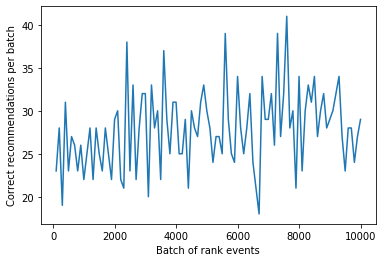

In [14]:
createChart(count, rewards) 

## Reading the chart

This chart shows the success of the current learning policy for the duration of the test. The ideal target that by the end of the test, the loop is averaging a success rate that is close to one hundred percent minus the exploration. The default setting of exploration is 20%. 

`100-20=80`

This exploration setting is found in the Azure portal, for the Personalizer resource, on the **Settings** page. 

In order to find a better learning policy, based on your data to the Rank API, run an [offline evaluation](how-to-offline-evaluation.md) in the portal for your Personalizer loop.

## Run an offline evaluation

1. In the Azure portal, open the Personalizer resource's **Evaluations** page.
1. Select **Create Evaluation**.
1. Enter the required data of evaluation name, and date range for the loop evaluation. The date range should include only the days you are focusing on for your evaluation. 

    The purpose of running this offline evaluation is to determine if there is a better learning policy for the features and actions used in this loop. To find that better learning policy, make sure **Optimization policy** is turned on.

1. Select **OK** to begin the evaluation. 
1. This **Evaluations** page lists the new evaluation and its current status. Depending on how much data you have, this evaluation can take some time. You can come back to this page after a few minutes to see the results. 
1. When the evaluation is completed, select the evaluation then select **Comparison of different learning policies**. This shows the available learning policies and how they would behave with the data. 
1. Select the top-most learning policy in the table and select **Apply**. This applies the _best_ learning policy to your model and retrains. 

## Change update model frequency to 5 minutes

1. In the Azure portal, still on the Personalizer resource, select the **Settings** page. 
1. Change the **model update frequency** and **reward wait time** to 5 minutes and select **Save**.

Learn more about the [reward wait time](https://docs.microsoft.com/en-us/azure/cognitive-services/personalizer/concept-rewards#reward-wait-time) and [model update frequency](https://docs.microsoft.com/en-us/azure/cognitive-services/personalizer/how-to-settings#model-update-frequency).

In [ ]:
#Verify new learning policy and times
get_service_settings()

## Validate new learning policy by running experiment for 2,000 iterations

Return to the Azure notebook, and continue by running the same loop but for only 2,000 iterations. 

In [15]:
# max iterations
num_requests = 2000

# check last mod date N% of time - currently 10%
lastModCheck2 = int(num_requests * .10)

jsonTemplate2 = rankactionsjsonobj

# main iterations
[count2, rewards2] = iterations(num_requests, lastModCheck2, jsonTemplate2)

2019-10-01 14:54:21.759830
   1 None Bob Snowy Afternoon Iced mocha 1 
2019-10-01 14:54:22.171822
   2 None Dave Snowy Afternoon Latte 0 
2019-10-01 14:54:22.510826
   3 None Cathy Snowy Evening Iced mocha 0 
2019-10-01 14:54:22.849823
   4 None Cathy Snowy Afternoon Latte 0 
2019-10-01 14:54:23.119823
   5 None Cathy Rainy Afternoon Iced mocha 0 
2019-10-01 14:54:23.377822
   6 None Cathy Sunny Evening Latte 0 
2019-10-01 14:54:23.619823
   7 None Alice Snowy Afternoon Iced mocha 0 
2019-10-01 14:54:23.881840
   8 None Cathy Sunny Morning Iced mocha 0 
2019-10-01 14:54:24.276827
   9 None Dave Rainy Morning Iced mocha 0 
2019-10-01 14:54:24.528336
   10 None Alice Rainy Evening Iced mocha 0 
2019-10-01 14:54:24.789336
   11 None Bob Rainy Evening Iced mocha 0 
2019-10-01 14:54:25.153932
   12 None Bob Sunny Afternoon Iced mocha 1 
2019-10-01 14:54:25.464918
   13 None Bob Snowy Evening Iced mocha 1 
2019-10-01 14:54:25.916492
   14 None Bob Rainy Morning Iced mocha 0 
2019-10-01 14:54

2019-10-01 14:55:13.516255
   115 None Cathy Sunny Afternoon Iced mocha 0 
2019-10-01 14:55:13.877756
   116 None Dave Sunny Morning Iced mocha 1 
2019-10-01 14:55:14.236761
   117 None Alice Rainy Morning Iced mocha 0 
2019-10-01 14:55:14.674771
   118 None Alice Rainy Afternoon Cold brew 0 
2019-10-01 14:55:15.180772
   119 None Dave Snowy Evening Iced mocha 0 
2019-10-01 14:55:15.613859
   120 None Bob Snowy Evening Cappucino 0 
2019-10-01 14:55:16.085865
   121 None Bob Snowy Morning Iced mocha 1 
2019-10-01 14:55:16.505868
   122 None Dave Rainy Morning Latte 1 
2019-10-01 14:55:16.889886
   123 None Dave Rainy Evening Cold brew 0 
2019-10-01 14:55:17.426862
   124 None Cathy Sunny Morning Latte 1 
2019-10-01 14:55:17.845879
   125 None Dave Rainy Evening Iced mocha 0 
2019-10-01 14:55:18.532872
   126 None Alice Sunny Morning Iced mocha 0 
2019-10-01 14:55:18.954848
   127 None Alice Snowy Morning Iced mocha 0 
2019-10-01 14:55:19.532860
   128 None Alice Rainy Morning Iced mocha

2019-10-01 14:56:08.359957
   225 None Alice Rainy Evening Iced mocha 0 
2019-10-01 14:56:08.843944
   226 None Cathy Snowy Afternoon Iced mocha 1 
2019-10-01 14:56:09.546944
   227 None Dave Sunny Afternoon Iced mocha 1 
2019-10-01 14:56:10.048950
   228 None Bob Snowy Morning Latte 0 
2019-10-01 14:56:10.491943
   229 None Alice Rainy Evening Iced mocha 0 
2019-10-01 14:56:10.989947
   230 None Bob Rainy Morning Cold brew 0 
2019-10-01 14:56:11.573935
   231 None Dave Sunny Afternoon Iced mocha 1 
2019-10-01 14:56:12.069944
   232 None Cathy Snowy Morning Iced mocha 0 
2019-10-01 14:56:12.792937
   233 None Alice Sunny Evening Cold brew 1 
2019-10-01 14:56:13.230955
   234 None Bob Rainy Morning Cappucino 0 
2019-10-01 14:56:13.728954
   235 None Dave Sunny Evening Iced mocha 1 
2019-10-01 14:56:14.092937
   236 None Dave Rainy Morning Iced mocha 0 
2019-10-01 14:56:14.569531
   237 None Dave Rainy Afternoon Iced mocha 0 
2019-10-01 14:56:14.993517
   238 None Dave Rainy Afternoon Ic

2019-10-01 14:56:58.378488
   338 None Dave Sunny Afternoon Iced mocha 1 
2019-10-01 14:56:58.690489
   339 None Alice Sunny Afternoon Iced mocha 1 
2019-10-01 14:56:58.997490
   340 None Bob Rainy Morning Cold brew 0 
2019-10-01 14:56:59.364490
   341 None Alice Snowy Evening Iced mocha 0 
2019-10-01 14:56:59.709490
   342 None Cathy Rainy Morning Iced mocha 0 
2019-10-01 14:57:00.035051
   343 None Alice Rainy Afternoon Cold brew 0 
2019-10-01 14:57:00.603686
   344 None Cathy Rainy Afternoon Cold brew 0 
2019-10-01 14:57:01.011761
   345 None Alice Rainy Evening Iced mocha 0 
2019-10-01 14:57:01.325759
   346 None Cathy Rainy Morning Iced mocha 0 
2019-10-01 14:57:01.817802
   347 None Dave Sunny Evening Iced mocha 1 
2019-10-01 14:57:02.234844
   348 None Cathy Snowy Evening Iced mocha 0 
2019-10-01 14:57:02.623856
   349 None Cathy Sunny Evening Iced mocha 0 
2019-10-01 14:57:02.947861
   350 None Dave Snowy Evening Iced mocha 0 
2019-10-01 14:57:03.301845
   351 None Dave Sunny M

2019-10-01 14:57:44.595031
   448 None Alice Rainy Morning Iced mocha 0 
2019-10-01 14:57:45.086027
   449 None Bob Sunny Afternoon Iced mocha 1 
2019-10-01 14:57:45.592025
   450 None Dave Snowy Afternoon Latte 0 
2019-10-01 14:57:45.995020
   451 None Alice Sunny Evening Iced mocha 0 
2019-10-01 14:57:46.386024
   452 None Alice Sunny Evening Iced mocha 0 
2019-10-01 14:57:46.792024
   453 None Dave Snowy Afternoon Cold brew 0 
2019-10-01 14:57:47.241024
   454 None Dave Rainy Evening Iced mocha 0 
2019-10-01 14:57:47.676022
   455 None Dave Rainy Morning Iced mocha 0 
2019-10-01 14:57:48.207140
   456 None Bob Sunny Morning Iced mocha 0 
2019-10-01 14:57:48.585141
   457 None Bob Sunny Afternoon Iced mocha 1 
2019-10-01 14:57:49.018129
   458 None Alice Rainy Evening Iced mocha 0 
2019-10-01 14:57:49.437143
   459 None Dave Rainy Morning Iced mocha 0 
2019-10-01 14:57:49.982131
   460 None Dave Snowy Afternoon Iced mocha 0 
2019-10-01 14:57:50.320131
   461 None Cathy Snowy Afternoo

2019-10-01 14:59:05.043888
   562 None Cathy Snowy Morning Iced mocha 0 
2019-10-01 14:59:05.342889
   563 None Dave Snowy Evening Iced mocha 0 
2019-10-01 14:59:05.697891
   564 None Alice Rainy Evening Iced mocha 0 
2019-10-01 14:59:06.176889
   565 None Bob Rainy Evening Iced mocha 0 
2019-10-01 14:59:06.475892
   566 None Alice Sunny Evening Iced mocha 0 
2019-10-01 14:59:06.777889
   567 None Dave Snowy Morning Iced mocha 0 
2019-10-01 14:59:07.058892
   568 None Dave Sunny Morning Iced mocha 1 
2019-10-01 14:59:07.389889
   569 None Dave Rainy Morning Iced mocha 0 
2019-10-01 14:59:07.694891
   570 None Bob Snowy Morning Iced mocha 1 
2019-10-01 14:59:08.309890
   571 None Cathy Snowy Afternoon Iced mocha 1 
2019-10-01 14:59:08.613891
   572 None Alice Snowy Afternoon Iced mocha 0 
2019-10-01 14:59:09.152892
   573 None Dave Rainy Afternoon Iced mocha 0 
2019-10-01 14:59:09.454891
   574 None Bob Snowy Morning Iced mocha 1 
2019-10-01 14:59:09.776893
   575 None Alice Snowy Eveni

2019-10-01 14:59:47.917733
   673 None Alice Snowy Morning Iced mocha 0 
2019-10-01 14:59:48.414738
   674 None Bob Rainy Afternoon Iced mocha 0 
2019-10-01 14:59:49.017726
   675 None Dave Sunny Evening Iced mocha 1 
2019-10-01 14:59:49.476734
   676 None Bob Snowy Morning Iced mocha 1 
2019-10-01 14:59:50.087754
   677 None Bob Snowy Evening Iced mocha 1 
2019-10-01 14:59:50.575727
   678 None Alice Snowy Afternoon Iced mocha 0 
2019-10-01 14:59:51.032721
   679 None Dave Snowy Morning Iced mocha 0 
2019-10-01 14:59:51.447280
   680 None Alice Rainy Morning Iced mocha 0 
2019-10-01 14:59:51.993287
   681 None Cathy Snowy Morning Latte 0 
2019-10-01 14:59:52.541281
   682 None Dave Rainy Afternoon Iced mocha 0 
2019-10-01 14:59:52.830290
   683 None Alice Sunny Afternoon Iced mocha 1 
2019-10-01 14:59:53.100290
   684 None Alice Rainy Morning Iced mocha 0 
2019-10-01 14:59:53.559301
   685 None Dave Rainy Morning Iced mocha 0 
2019-10-01 14:59:53.967302
   686 None Bob Rainy Evening I

2019-10-01 15:00:48.828645
   787 None Cathy Snowy Evening Iced mocha 0 
2019-10-01 15:00:49.236627
   788 None Alice Sunny Evening Cold brew 1 
2019-10-01 15:00:49.642777
   789 None Cathy Sunny Morning Cold brew 0 
2019-10-01 15:00:50.093984
   790 None Cathy Rainy Evening Latte 0 
2019-10-01 15:00:50.497968
   791 None Alice Snowy Evening Cappucino 1 
2019-10-01 15:00:51.114689
   792 None Dave Sunny Evening Iced mocha 1 
2019-10-01 15:00:51.696834
   793 None Cathy Rainy Afternoon Cappucino 0 
2019-10-01 15:00:52.191453
   794 None Dave Rainy Evening Latte 1 
2019-10-01 15:00:52.687014
   795 None Cathy Snowy Morning Cappucino 0 
2019-10-01 15:00:53.037006
   796 None Cathy Sunny Afternoon Iced mocha 0 
2019-10-01 15:00:53.516016
   797 None Dave Snowy Morning Cappucino 1 
2019-10-01 15:00:53.852347
   798 None Alice Rainy Morning Latte 1 
2019-10-01 15:00:54.226351
   799 None Alice Sunny Evening Cold brew 1 
2019-10-01 15:00:54.593370
   800 None Dave Rainy Evening Latte 1 
**** 

2019-10-01 15:01:39.829325
   900 None Cathy Rainy Morning Latte 0 
**** aggregating rewards
2019-10-01 15:01:40.300880
   901 None Bob Rainy Evening Latte 1 
2019-10-01 15:01:40.829875
   902 None Bob Sunny Morning Iced mocha 0 
2019-10-01 15:01:41.169929
   903 None Bob Sunny Afternoon Iced mocha 1 
2019-10-01 15:01:41.458928
   904 None Bob Sunny Morning Iced mocha 0 
2019-10-01 15:01:42.031622
   905 None Alice Rainy Evening Latte 1 
2019-10-01 15:01:42.489771
   906 None Bob Rainy Morning Latte 1 
2019-10-01 15:01:42.935761
   907 None Cathy Snowy Evening Iced mocha 0 
2019-10-01 15:01:43.400778
   908 None Cathy Snowy Morning Cappucino 0 
2019-10-01 15:01:43.777769
   909 None Cathy Sunny Evening Iced mocha 0 
2019-10-01 15:01:44.165763
   910 None Cathy Snowy Evening Iced mocha 0 
2019-10-01 15:01:44.498761
   911 None Alice Sunny Afternoon Iced mocha 1 
2019-10-01 15:01:44.911759
   912 None Cathy Sunny Afternoon Iced mocha 0 
2019-10-01 15:01:45.222761
   913 None Alice Sunny 

2019-10-01 15:02:33.939583
   1012 None Alice Rainy Afternoon Latte 0 
2019-10-01 15:02:34.355571
   1013 None Alice Sunny Evening Cold brew 1 
2019-10-01 15:02:34.800589
   1014 None Cathy Snowy Afternoon Iced mocha 1 
2019-10-01 15:02:35.388581
   1015 None Cathy Sunny Morning Cold brew 0 
2019-10-01 15:02:35.816596
   1016 None Bob Snowy Afternoon Iced mocha 1 
2019-10-01 15:02:36.202573
   1017 None Bob Rainy Evening Latte 1 
2019-10-01 15:02:36.770172
   1018 None Alice Snowy Morning Cappucino 1 
2019-10-01 15:02:37.304179
   1019 None Dave Sunny Morning Cappucino 0 
2019-10-01 15:02:37.911177
   1020 None Cathy Sunny Afternoon Iced mocha 0 
2019-10-01 15:02:38.311755
   1021 None Cathy Rainy Evening Iced mocha 1 
2019-10-01 15:02:38.653306
   1022 None Dave Sunny Morning Iced mocha 1 
2019-10-01 15:02:39.096840
   1023 None Dave Rainy Morning Latte 1 
2019-10-01 15:02:39.526824
   1024 None Bob Rainy Afternoon Latte 1 
2019-10-01 15:02:40.009352
   1025 None Dave Sunny Morning Ca

2019-10-01 15:03:26.950059
   1125 None Cathy Rainy Morning Iced mocha 0 
2019-10-01 15:03:27.308079
   1126 None Alice Snowy Morning Cappucino 1 
2019-10-01 15:03:27.766135
   1127 None Cathy Sunny Morning Cold brew 0 
2019-10-01 15:03:28.183063
   1128 None Cathy Rainy Afternoon Iced mocha 0 
2019-10-01 15:03:28.639073
   1129 None Bob Rainy Evening Latte 1 
2019-10-01 15:03:29.096075
   1130 None Bob Sunny Evening Iced mocha 0 
2019-10-01 15:03:29.680080
   1131 None Bob Snowy Afternoon Iced mocha 1 
2019-10-01 15:03:30.110072
   1132 None Alice Snowy Morning Cappucino 1 
2019-10-01 15:03:30.401092
   1133 None Alice Snowy Evening Cappucino 1 
2019-10-01 15:03:30.714141
   1134 None Dave Snowy Morning Cappucino 1 
2019-10-01 15:03:31.060093
   1135 None Alice Snowy Afternoon Cappucino 1 
2019-10-01 15:03:31.594107
   1136 None Bob Sunny Afternoon Iced mocha 1 
2019-10-01 15:03:32.079103
   1137 None Dave Sunny Evening Iced mocha 1 
2019-10-01 15:03:32.532104
   1138 None Cathy Snowy

2019-10-01 15:04:21.791339
   1237 None Dave Snowy Evening Cappucino 1 
2019-10-01 15:04:22.266301
   1238 None Alice Snowy Morning Iced mocha 0 
2019-10-01 15:04:22.840303
   1239 None Alice Sunny Evening Latte 0 
2019-10-01 15:04:23.247304
   1240 None Dave Snowy Morning Latte 0 
2019-10-01 15:04:23.727314
   1241 None Alice Rainy Morning Latte 1 
2019-10-01 15:04:24.423309
   1242 None Dave Rainy Evening Latte 1 
2019-10-01 15:04:24.855339
   1243 None Alice Snowy Afternoon Cappucino 1 
2019-10-01 15:04:25.387310
   1244 None Dave Rainy Morning Latte 1 
2019-10-01 15:04:25.864308
   1245 None Dave Sunny Morning Cold brew 0 
2019-10-01 15:04:26.287894
   1246 None Alice Snowy Afternoon Cappucino 1 
2019-10-01 15:04:26.815892
   1247 None Bob Rainy Evening Latte 1 
2019-10-01 15:04:27.347909
   1248 None Dave Snowy Afternoon Latte 0 
2019-10-01 15:04:27.744883
   1249 None Alice Snowy Morning Cappucino 1 
2019-10-01 15:04:28.489451
   1250 None Bob Rainy Afternoon Latte 1 
2019-10-01 

2019-10-01 15:05:11.391866
   1352 None Dave Rainy Morning Latte 1 
2019-10-01 15:05:12.033860
   1353 None Dave Snowy Morning Cappucino 1 
2019-10-01 15:05:12.424862
   1354 None Alice Snowy Evening Cappucino 1 
2019-10-01 15:05:12.857863
   1355 None Bob Rainy Evening Latte 1 
2019-10-01 15:05:13.255872
   1356 None Alice Rainy Afternoon Latte 0 
2019-10-01 15:05:13.644873
   1357 None Cathy Rainy Afternoon Latte 1 
2019-10-01 15:05:14.159869
   1358 None Alice Rainy Afternoon Latte 0 
2019-10-01 15:05:14.602867
   1359 None Cathy Rainy Afternoon Iced mocha 0 
2019-10-01 15:05:15.046870
   1360 None Dave Sunny Morning Iced mocha 1 
2019-10-01 15:05:15.468865
   1361 None Dave Snowy Afternoon Iced mocha 0 
2019-10-01 15:05:15.977389
   1362 None Dave Sunny Morning Iced mocha 1 
2019-10-01 15:05:16.337390
   1363 None Bob Rainy Morning Latte 1 
2019-10-01 15:05:16.641905
   1364 None Cathy Snowy Afternoon Iced mocha 1 
2019-10-01 15:05:17.058489
   1365 None Alice Rainy Evening Iced mo

2019-10-01 15:05:57.022763
   1463 None Bob Snowy Afternoon Iced mocha 1 
2019-10-01 15:05:57.420849
   1464 None Dave Sunny Evening Cappucino 0 
2019-10-01 15:05:57.930763
   1465 None Alice Snowy Afternoon Cappucino 1 
2019-10-01 15:05:58.413772
   1466 None Cathy Sunny Morning Cappucino 0 
2019-10-01 15:05:58.831755
   1467 None Bob Snowy Morning Iced mocha 1 
2019-10-01 15:05:59.451753
   1468 None Bob Snowy Morning Iced mocha 1 
2019-10-01 15:06:00.153755
   1469 None Cathy Sunny Afternoon Iced mocha 0 
2019-10-01 15:06:00.448754
   1470 None Dave Sunny Afternoon Iced mocha 1 
2019-10-01 15:06:00.788787
   1471 None Dave Sunny Afternoon Iced mocha 1 
2019-10-01 15:06:01.304768
   1472 None Dave Rainy Afternoon Iced mocha 0 
2019-10-01 15:06:01.976788
   1473 None Cathy Snowy Evening Cappucino 1 
2019-10-01 15:06:02.400769
   1474 None Alice Rainy Evening Latte 1 
2019-10-01 15:06:02.939772
   1475 None Dave Rainy Evening Latte 1 
2019-10-01 15:06:03.579776
   1476 None Bob Snowy M

2019-10-01 15:06:53.505192
   1577 None Alice Rainy Afternoon Latte 0 
2019-10-01 15:06:54.002185
   1578 None Cathy Rainy Afternoon Latte 1 
2019-10-01 15:06:54.482831
   1579 None Cathy Sunny Evening Cappucino 1 
2019-10-01 15:06:54.875838
   1580 None Cathy Rainy Evening Latte 0 
2019-10-01 15:06:55.317821
   1581 None Alice Rainy Afternoon Cold brew 0 
2019-10-01 15:06:55.715831
   1582 None Cathy Rainy Afternoon Latte 1 
2019-10-01 15:06:56.145908
   1583 None Alice Snowy Afternoon Cappucino 1 
2019-10-01 15:06:56.549344
   1584 None Dave Sunny Afternoon Iced mocha 1 
2019-10-01 15:06:57.055347
   1585 None Cathy Sunny Morning Cappucino 0 
2019-10-01 15:06:57.460900
   1586 None Dave Snowy Afternoon Iced mocha 0 
2019-10-01 15:06:57.810887
   1587 None Cathy Rainy Morning Latte 0 
2019-10-01 15:06:58.306500
   1588 None Bob Snowy Morning Iced mocha 1 
2019-10-01 15:06:58.820021
   1589 None Alice Snowy Afternoon Cappucino 1 
2019-10-01 15:06:59.272630
   1590 None Bob Snowy Aftern

2019-10-01 15:07:43.549725
   1688 None Alice Sunny Evening Cappucino 0 
2019-10-01 15:07:44.082773
   1689 None Cathy Snowy Afternoon Cappucino 0 
2019-10-01 15:07:44.537725
   1690 None Dave Sunny Evening Cappucino 0 
2019-10-01 15:07:44.962735
   1691 None Cathy Snowy Morning Cappucino 0 
2019-10-01 15:07:45.286721
   1692 None Bob Sunny Afternoon Cappucino 0 
2019-10-01 15:07:45.710730
   1693 None Cathy Rainy Afternoon Latte 1 
2019-10-01 15:07:46.137725
   1694 None Dave Rainy Morning Latte 1 
2019-10-01 15:07:46.533725
   1695 None Dave Sunny Evening Cappucino 0 
2019-10-01 15:07:46.971730
   1696 None Dave Sunny Morning Iced mocha 1 
2019-10-01 15:07:47.481843
   1697 None Dave Sunny Morning Iced mocha 1 
2019-10-01 15:07:48.193845
   1698 None Cathy Snowy Morning Cappucino 0 
2019-10-01 15:07:48.522847
   1699 None Bob Snowy Evening Iced mocha 1 
2019-10-01 15:07:48.894832
   1700 None Dave Sunny Afternoon Cappucino 0 
**** aggregating rewards
2019-10-01 15:07:49.275845
   170

2019-10-01 15:08:39.036722
   1801 None Dave Rainy Morning Latte 1 
2019-10-01 15:08:39.487018
   1802 None Bob Rainy Evening Latte 1 
2019-10-01 15:08:40.105143
   1803 None Cathy Rainy Morning Latte 0 
2019-10-01 15:08:40.569190
   1804 None Alice Sunny Afternoon Cold brew 0 
2019-10-01 15:08:41.029108
   1805 None Bob Sunny Afternoon Iced mocha 1 
2019-10-01 15:08:41.452107
   1806 None Alice Snowy Evening Cappucino 1 
2019-10-01 15:08:42.186112
   1807 None Dave Snowy Morning Iced mocha 0 
2019-10-01 15:08:42.635602
   1808 None Bob Rainy Evening Latte 1 
2019-10-01 15:08:43.082604
   1809 None Alice Sunny Morning Cappucino 0 
2019-10-01 15:08:43.434799
   1810 None Cathy Snowy Afternoon Cold brew 0 
2019-10-01 15:08:43.945720
   1811 None Bob Snowy Morning Iced mocha 1 
2019-10-01 15:08:44.409719
   1812 None Bob Snowy Morning Iced mocha 1 
2019-10-01 15:08:44.792840
   1813 None Cathy Sunny Evening Cappucino 1 
2019-10-01 15:08:45.120821
   1814 None Cathy Rainy Afternoon Latte 1

2019-10-01 15:09:37.547746
   1915 None Cathy Snowy Evening Latte 0 
2019-10-01 15:09:38.082755
   1916 None Cathy Sunny Evening Cappucino 1 
2019-10-01 15:09:38.762745
   1917 None Dave Snowy Morning Cappucino 1 
2019-10-01 15:09:39.260822
   1918 None Cathy Rainy Morning Latte 0 
2019-10-01 15:09:39.740756
   1919 None Alice Snowy Evening Cappucino 1 
2019-10-01 15:09:40.164759
   1920 None Alice Sunny Afternoon Iced mocha 1 
2019-10-01 15:09:40.668750
   1921 None Dave Snowy Morning Cappucino 1 
2019-10-01 15:09:41.089747
   1922 None Dave Rainy Evening Latte 1 
2019-10-01 15:09:41.509747
   1923 None Alice Sunny Afternoon Iced mocha 1 
2019-10-01 15:09:41.903750
   1924 None Cathy Sunny Morning Cappucino 0 
2019-10-01 15:09:42.791762
   1925 None Dave Sunny Afternoon Iced mocha 1 
2019-10-01 15:09:43.386748
   1926 None Alice Rainy Morning Latte 1 
2019-10-01 15:09:43.997756
   1927 None Dave Rainy Evening Latte 1 
2019-10-01 15:09:44.398749
   1928 None Bob Sunny Afternoon Iced mo

## Run chart for 2,000 rank requests

Run the `createChart` function.

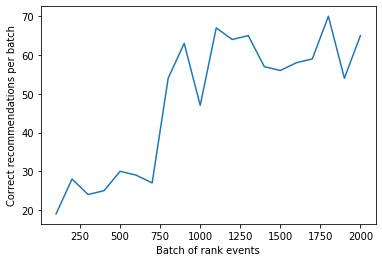

In [16]:
createChart(count2,rewards2)


## Review the second chart

The second chart should show a visible increase in Rank predictions aligning with user preferences. 

## Clean up resources

If you do not intend to continue the tutorial series, clean up the following resources:

* Delete your Azure Notebook project. 
* Delete your Personalizer resource. 